## Desafio: Engenheiro de Machine Learning - cloud2go

O dataset utilizado neste experimento contém informações de casas à venda, com diversas variáveis numéricas e categóricas, incluindo características do terreno, da construção, acabamentos, localização, garagem, porão, lareiras, entre outras. 

O objetivo é explorar os dados, selecionar as variáveis mais relevantes, tratar outliers e preparar os dados para modelos de predição da variável alvo SalePrice (preço de venda das casas).

(Desenvolvido por José Gama.)

### 1. Importando, explorando e tratando os dados

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge
from tqdm import tqdm
from xgboost import XGBRegressor

In [3]:
train_df = pd.read_csv('train.csv', sep = ',')
test_df = pd.read_csv('test.csv', sep = ';')

train_df.head(2)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,382,527359050,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2009,WD,Family,152000
1,835,906475070,60,RL,NaN,28698,Pave,NaN,IR2,Low,...,0,NaN,NaN,NaN,0,6,2009,WD,Abnorml,185000


In [4]:
train_df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

Primeiro, serão removidas as colunas referentes à identificação de cada entrada da base de treino, já que não servirão para a predição.

In [5]:
drop_cols = ['Order', 'PID']
train_df = train_df.drop(columns=drop_cols)

In [6]:
print(f'Dimensão dos dados de treino: {train_df.shape}')
print(f'Dimensão dos dados de teste: {test_df.shape}')

Dimensão dos dados de treino: (2344, 80)
Dimensão dos dados de teste: (586, 82)


In [7]:
print("Número de duplicados (treino):", train_df.duplicated().sum())
print("Número de duplicados (teste):", test_df.duplicated().sum())

Número de duplicados (treino): 0
Número de duplicados (teste): 0


In [8]:
null_counts = train_df.isnull().sum()
null_counts = null_counts[null_counts > 0]
print(f'Valores nulos por coluna: {null_counts}')

Valores nulos por coluna: Lot Frontage       393
Alley             2182
Mas Vnr Type      1426
Mas Vnr Area        19
Bsmt Qual           61
Bsmt Cond           61
Bsmt Exposure       63
BsmtFin Type 1      61
BsmtFin SF 1         1
BsmtFin Type 2      62
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       1
Bsmt Half Bath       1
Fireplace Qu      1144
Garage Type        120
Garage Yr Blt      122
Garage Finish      122
Garage Cars          1
Garage Area          1
Garage Qual        122
Garage Cond        122
Pool QC           2332
Fence             1874
Misc Feature      2250
dtype: int64


In [9]:
print(null_counts.index)

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
       'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature'],
      dtype='object')


#### Preenchimento de valores nulos

Existem colunas categóricas onde NaN significa ausência da característica<br>
Exemplo: se Alley é nulo = a casa não tem becos/vielas próximos; se FireplaceQu é nulo = não tem lareira

In [10]:
categoric_cols_none = [
    'Alley', 'Mas Vnr Type', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
    'BsmtFin SF 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Type',
    'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC',
    'Fence', 'Misc Feature'
]

for col in categoric_cols_none:
    train_df[col] = train_df[col].fillna("None")  

Colunas numéricas onde NaN significa que a estrutura não existe<br>
Exemplo: se GarageCars é nulo = não há garagem, então faz sentido preencher com 0

In [11]:
numeric_cols_zero = [
    'Mas Vnr Area', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
    'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
    'Garage Cars', 'Garage Area', 'Garage Yr Blt'
]

for col in numeric_cols_zero:
    train_df[col] = train_df[col].fillna(0)

Em particular, a coluna 'Lot Frontage' mede a largura do lote para a rua.<br>

Aqui os nulos não significam ausência dessa largura, apenas que o dado não foi registrado.<br>

Preencher com a mediana do bairro (coluna 'Neighborhood') mantém o valor realista e consistente com lotes próximos, sem ser distorcido por outliers. Caso todos os casos de um determinado bairro possuam valores nulos, cabe preencher com a mediana geral.<br>

In [12]:
train_df['Lot Frontage'] = train_df.groupby('Neighborhood')['Lot Frontage'].transform(lambda x: x.fillna(x.median()))
train_df['Lot Frontage'] = train_df['Lot Frontage'].fillna(train_df['Lot Frontage'].median())

c:\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [13]:
null_counts = train_df.isnull().sum()
null_counts = null_counts[null_counts > 0]

print(f'Quantidade de valores nulos restantes: {null_counts}')

Quantidade de valores nulos restantes: Series([], dtype: int64)


### 2. Observando relações entre as variáveis e lidando com outliers

As variáveis serão divididas em 2 tipos principais: numéricas e categóricas (incluindo as numérico-categóricas).

In [14]:
cat_as_num = ['MS SubClass', 'Mo Sold', 'Yr Sold']

train_df[cat_as_num] = train_df[cat_as_num].astype('category')

numerical = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Colunas Numéricas:", numerical)
print("Colunas Categóricas:", categorical)

Colunas Numéricas: ['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice']
Colunas Categóricas: ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Ele

O código abaixo calcula a correlação de Pearson entre cada variável numérica e a variável alvo SalePrice, em ordem decrescente, e exibe os resultados em um heatmap de coluna única

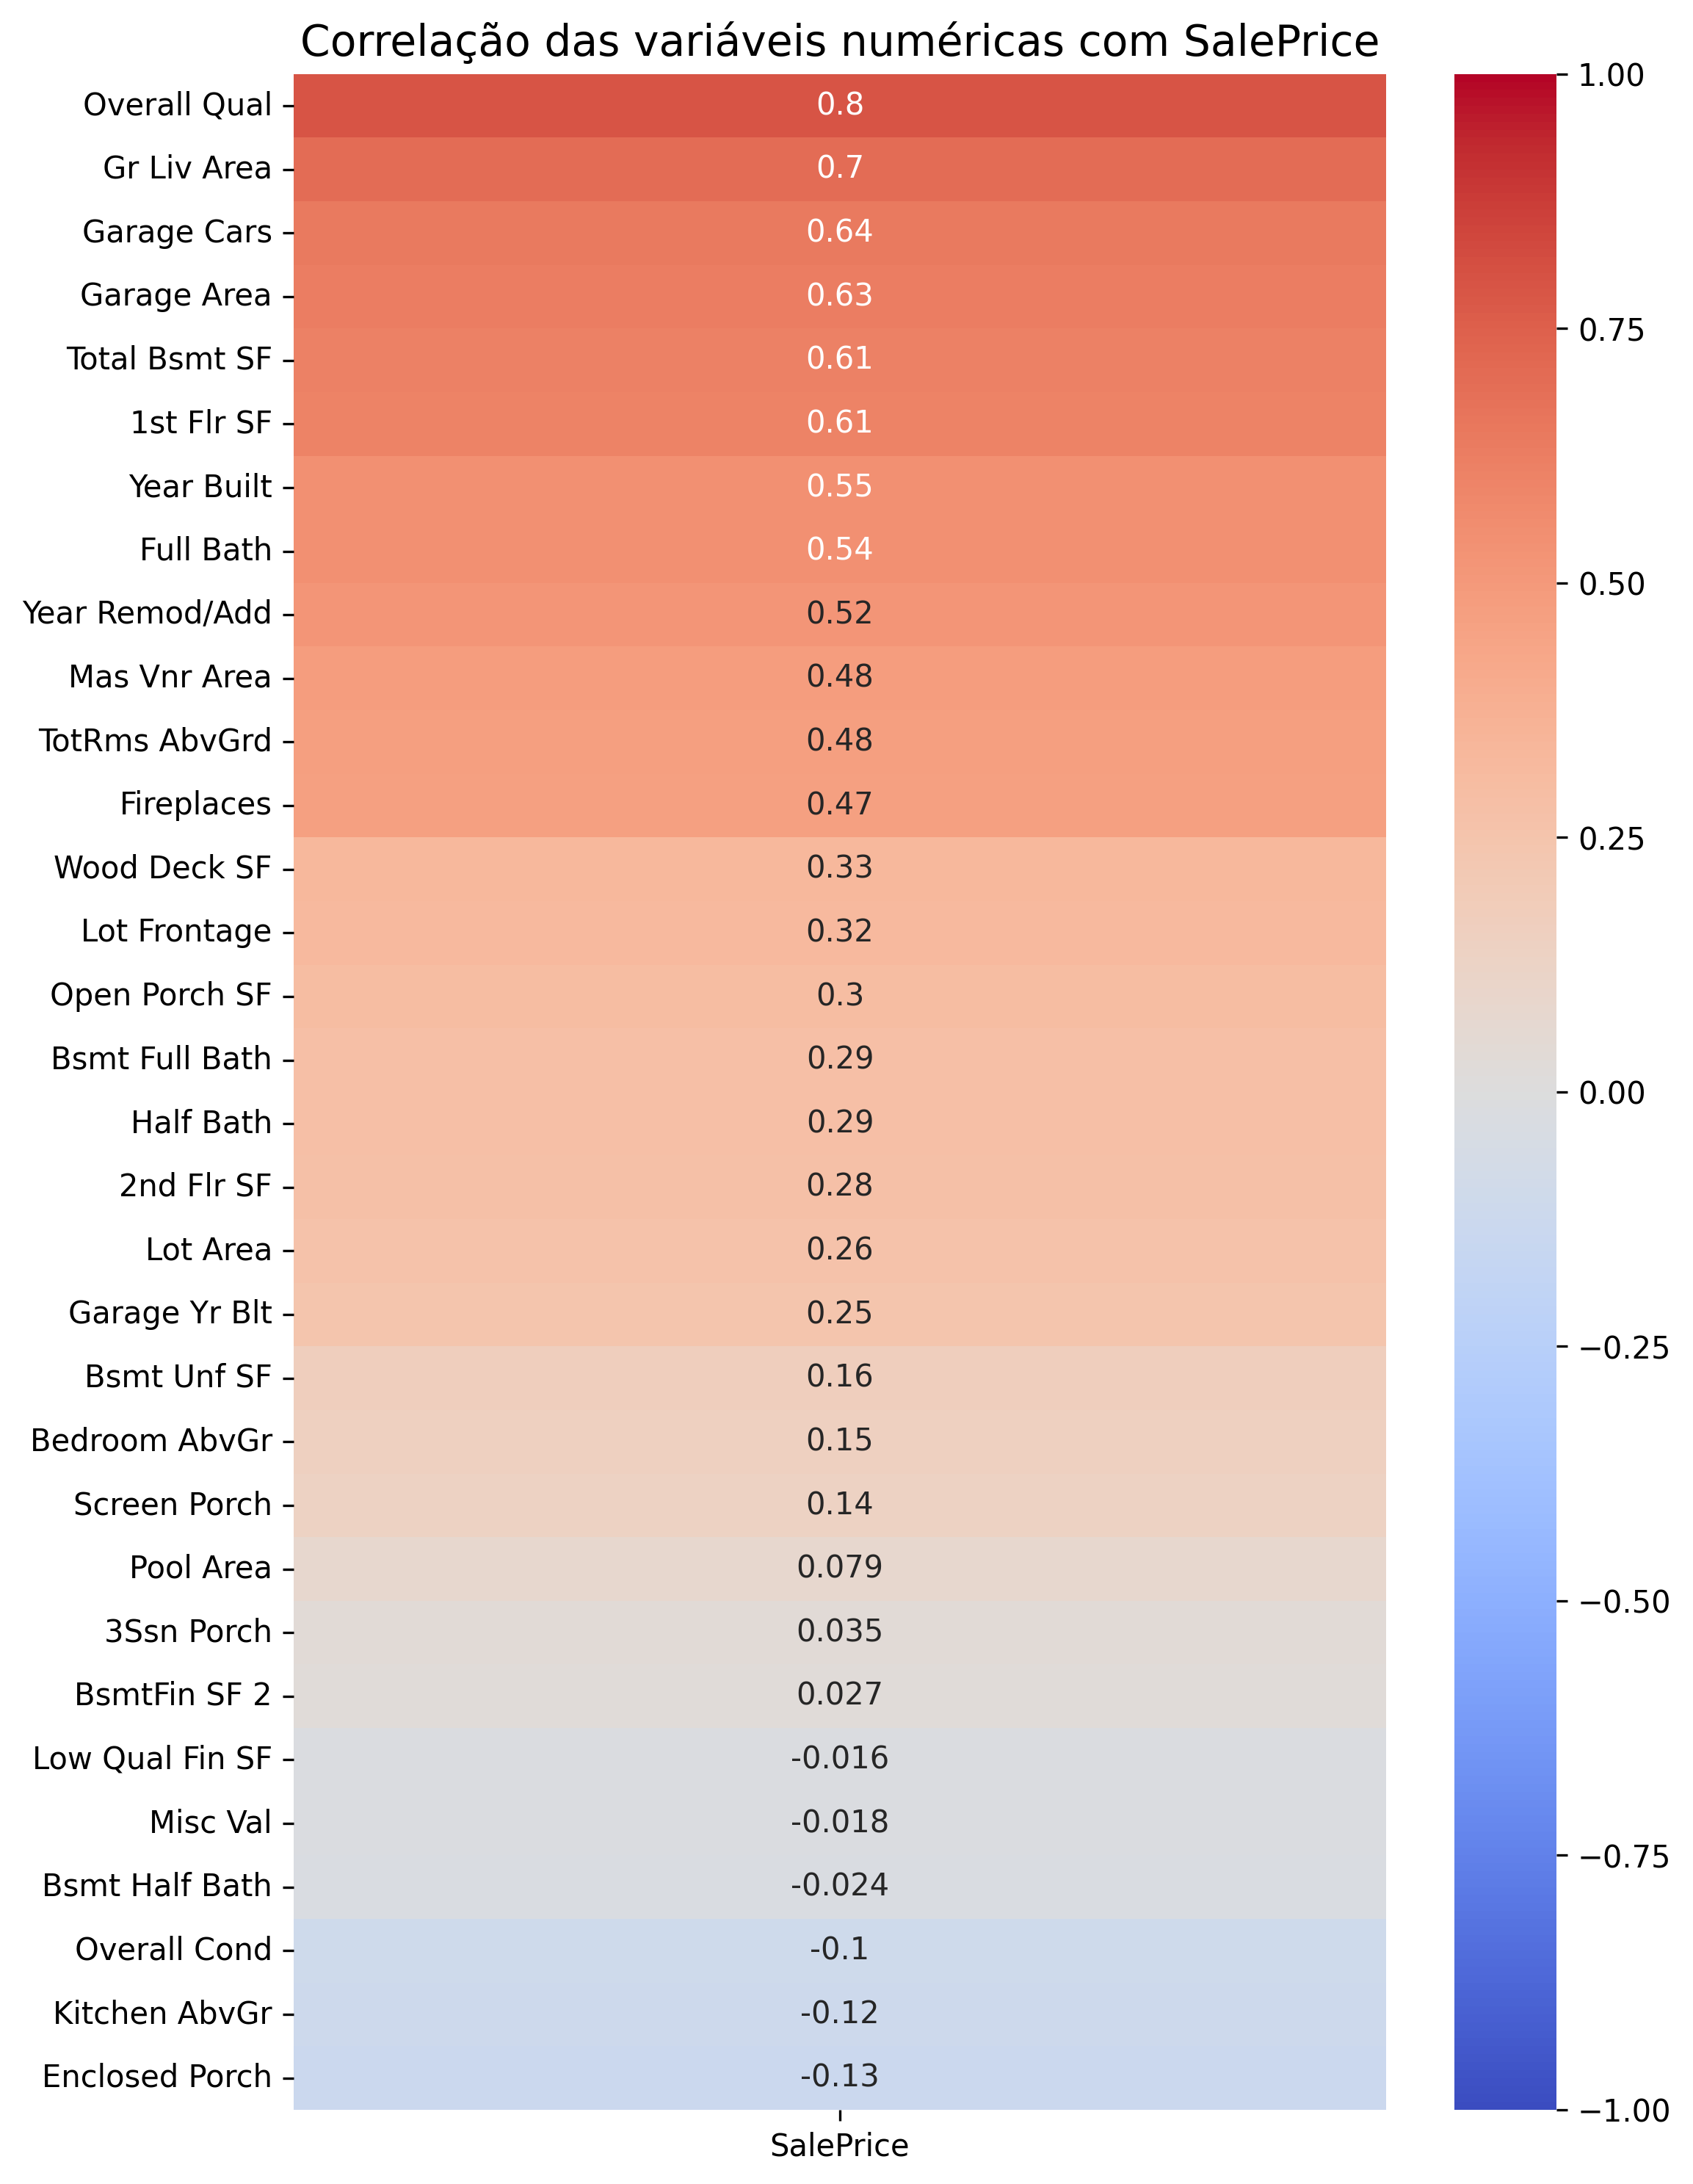

In [15]:
corr = train_df[numerical].corr()
target_corr = corr['SalePrice'].drop('SalePrice').sort_values(ascending=False)

plt.figure(figsize=(8, 12), dpi = 300)
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlação das variáveis numéricas com SalePrice", fontsize=14)
plt.show()

A partir das correlações observadas com a variável alvo, decidi por selecionar as top 10 com correlações mais fortes, o que resultou nas variáveis exibidas abaixo.

In [16]:
numeric_great_corr_varrs = list(target_corr.index[0:10])
numeric_great_corr_varrs

['Overall Qual',
 'Gr Liv Area',
 'Garage Cars',
 'Garage Area',
 'Total Bsmt SF',
 '1st Flr SF',
 'Year Built',
 'Full Bath',
 'Year Remod/Add',
 'Mas Vnr Area']

Para as variáveis categóricas, que são muitas, estão plotados abaixos os boxplots de 15 das quais julguei serem influentes em relação à variável alvo, a partir da leitura da descrição.<br>

A ideia é verificar se as medianas dos preços de venda variam dentre as categorias de cada variável.<br> Se sim, então a variável é uma forte candidata a influenciar no preço de venda final.

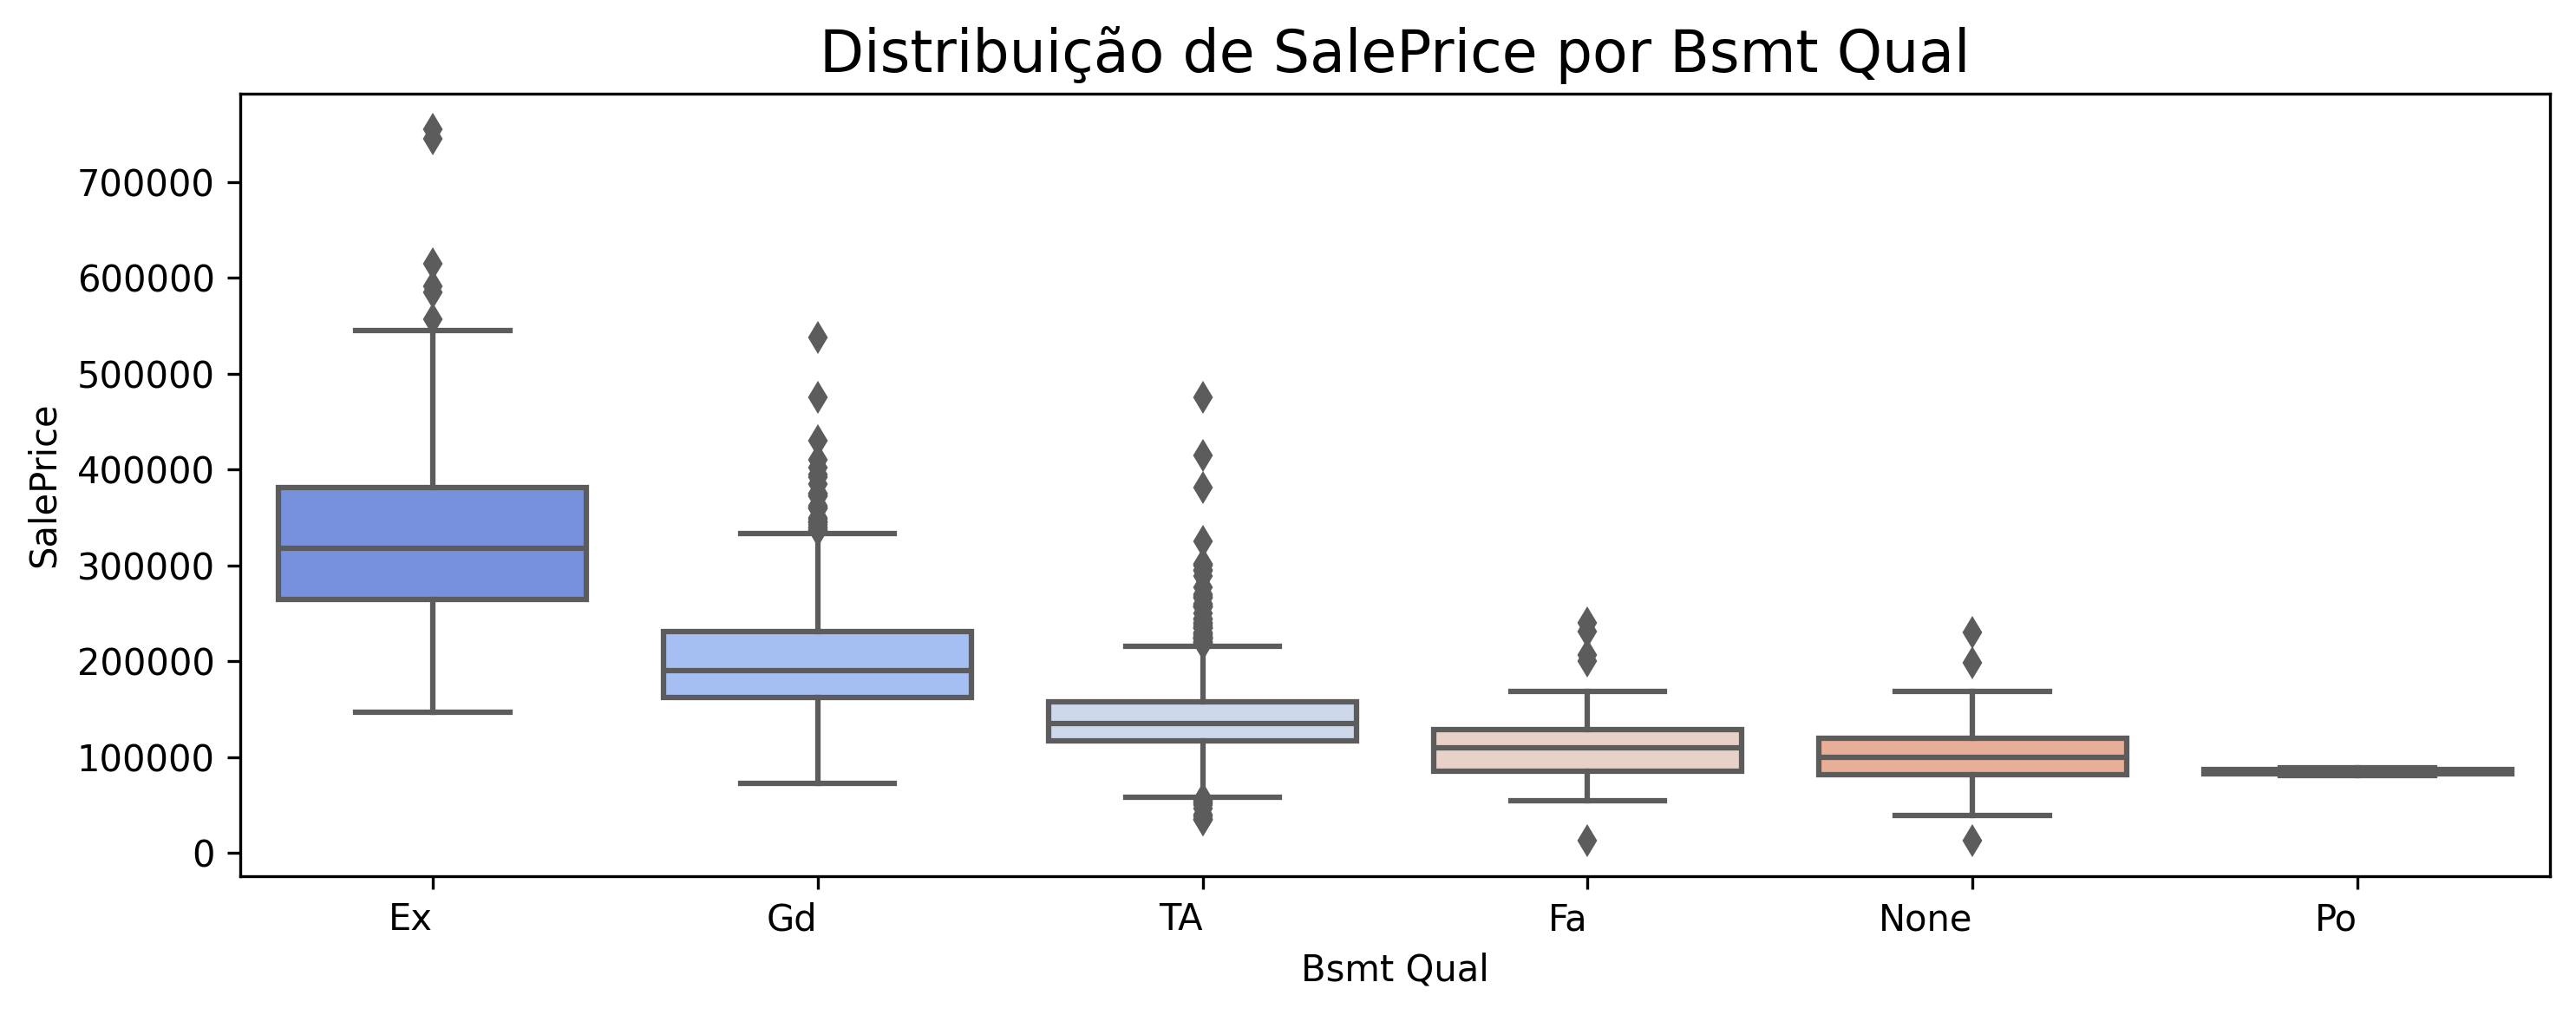

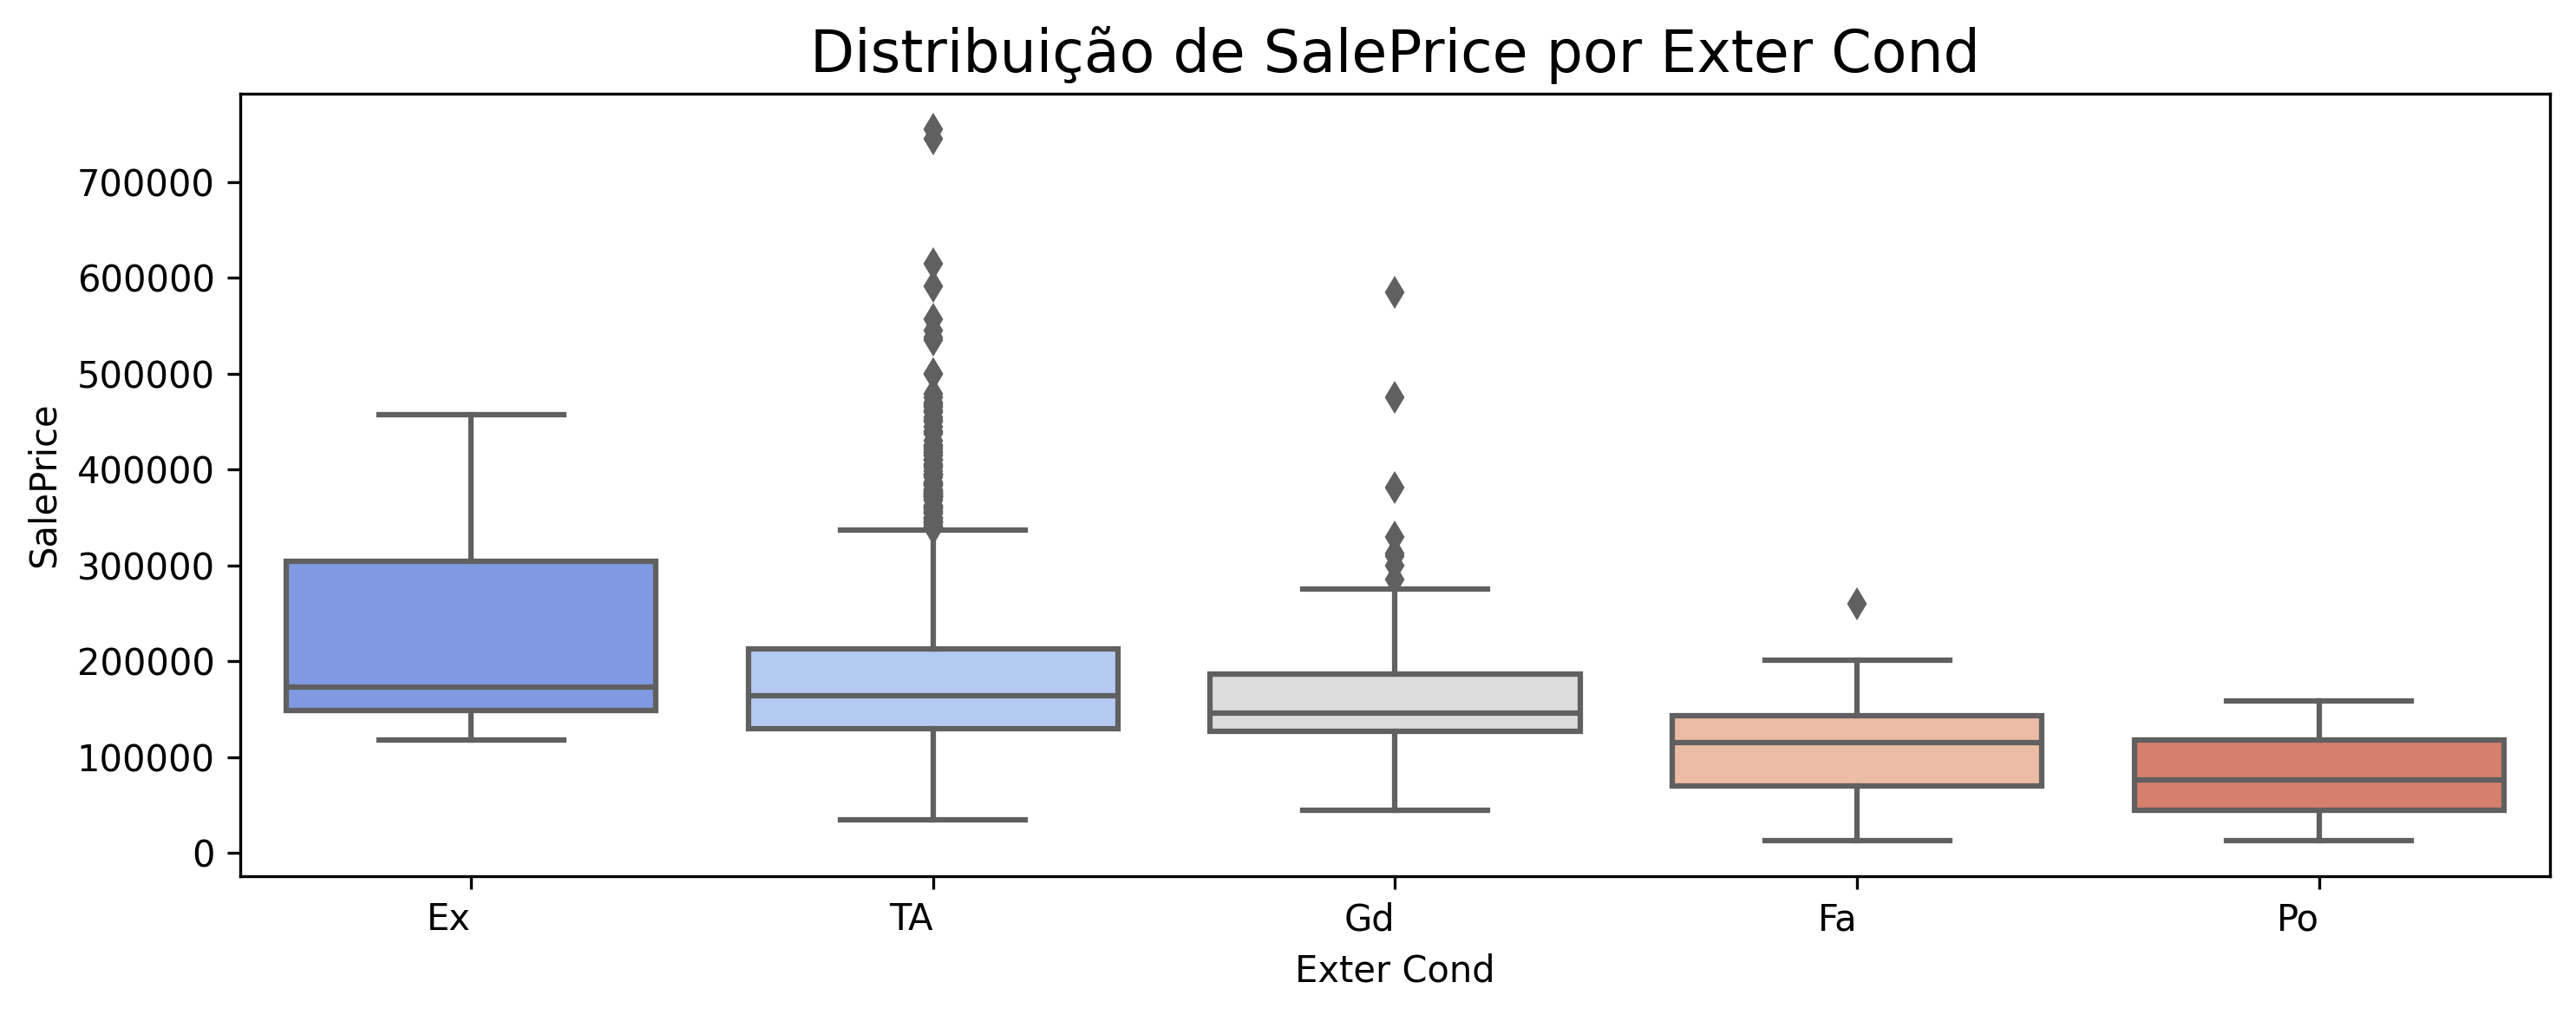

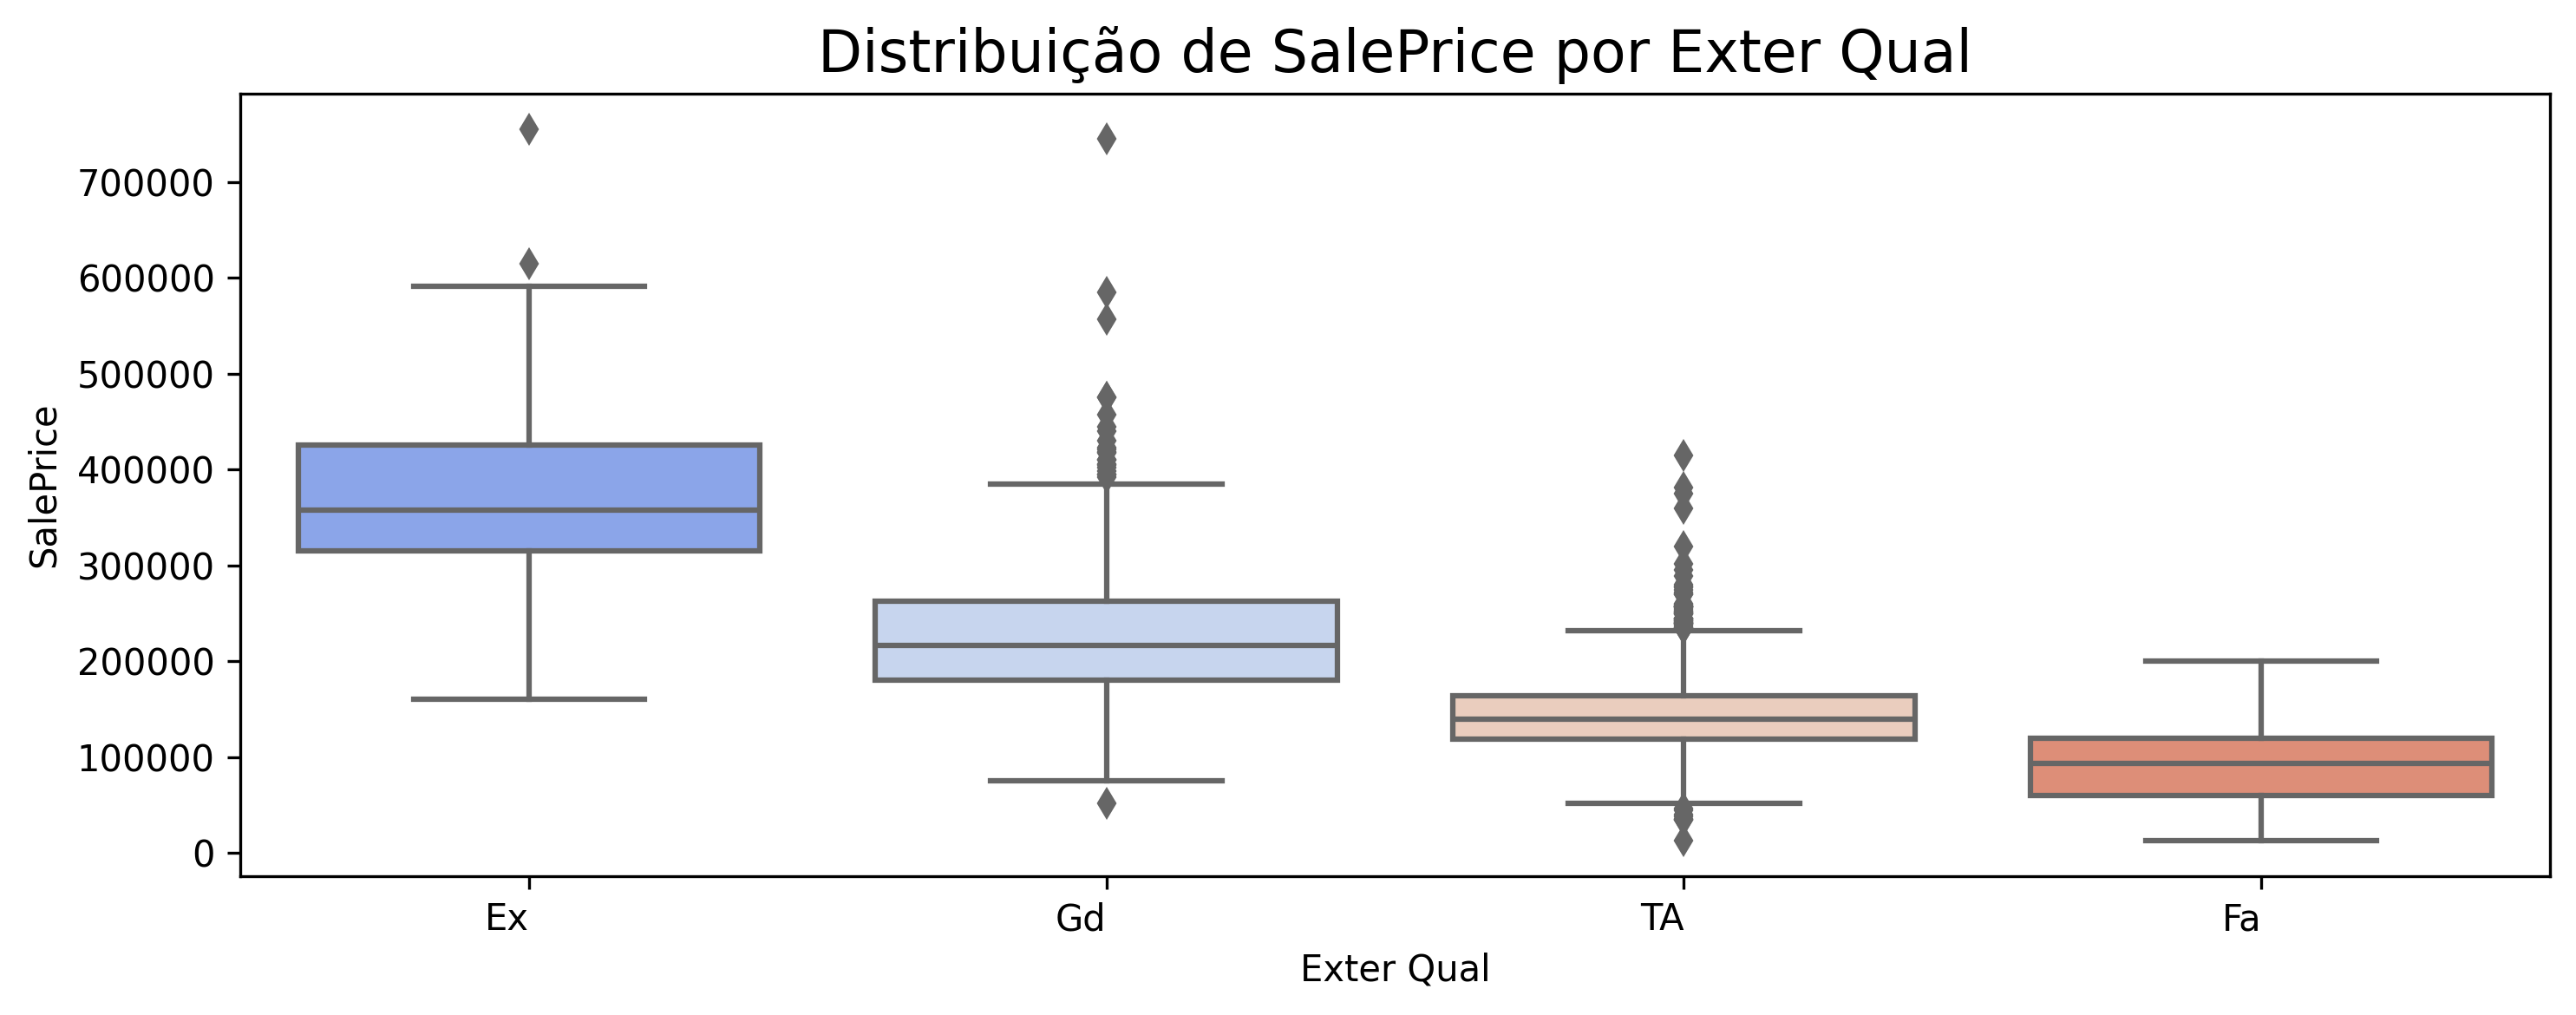

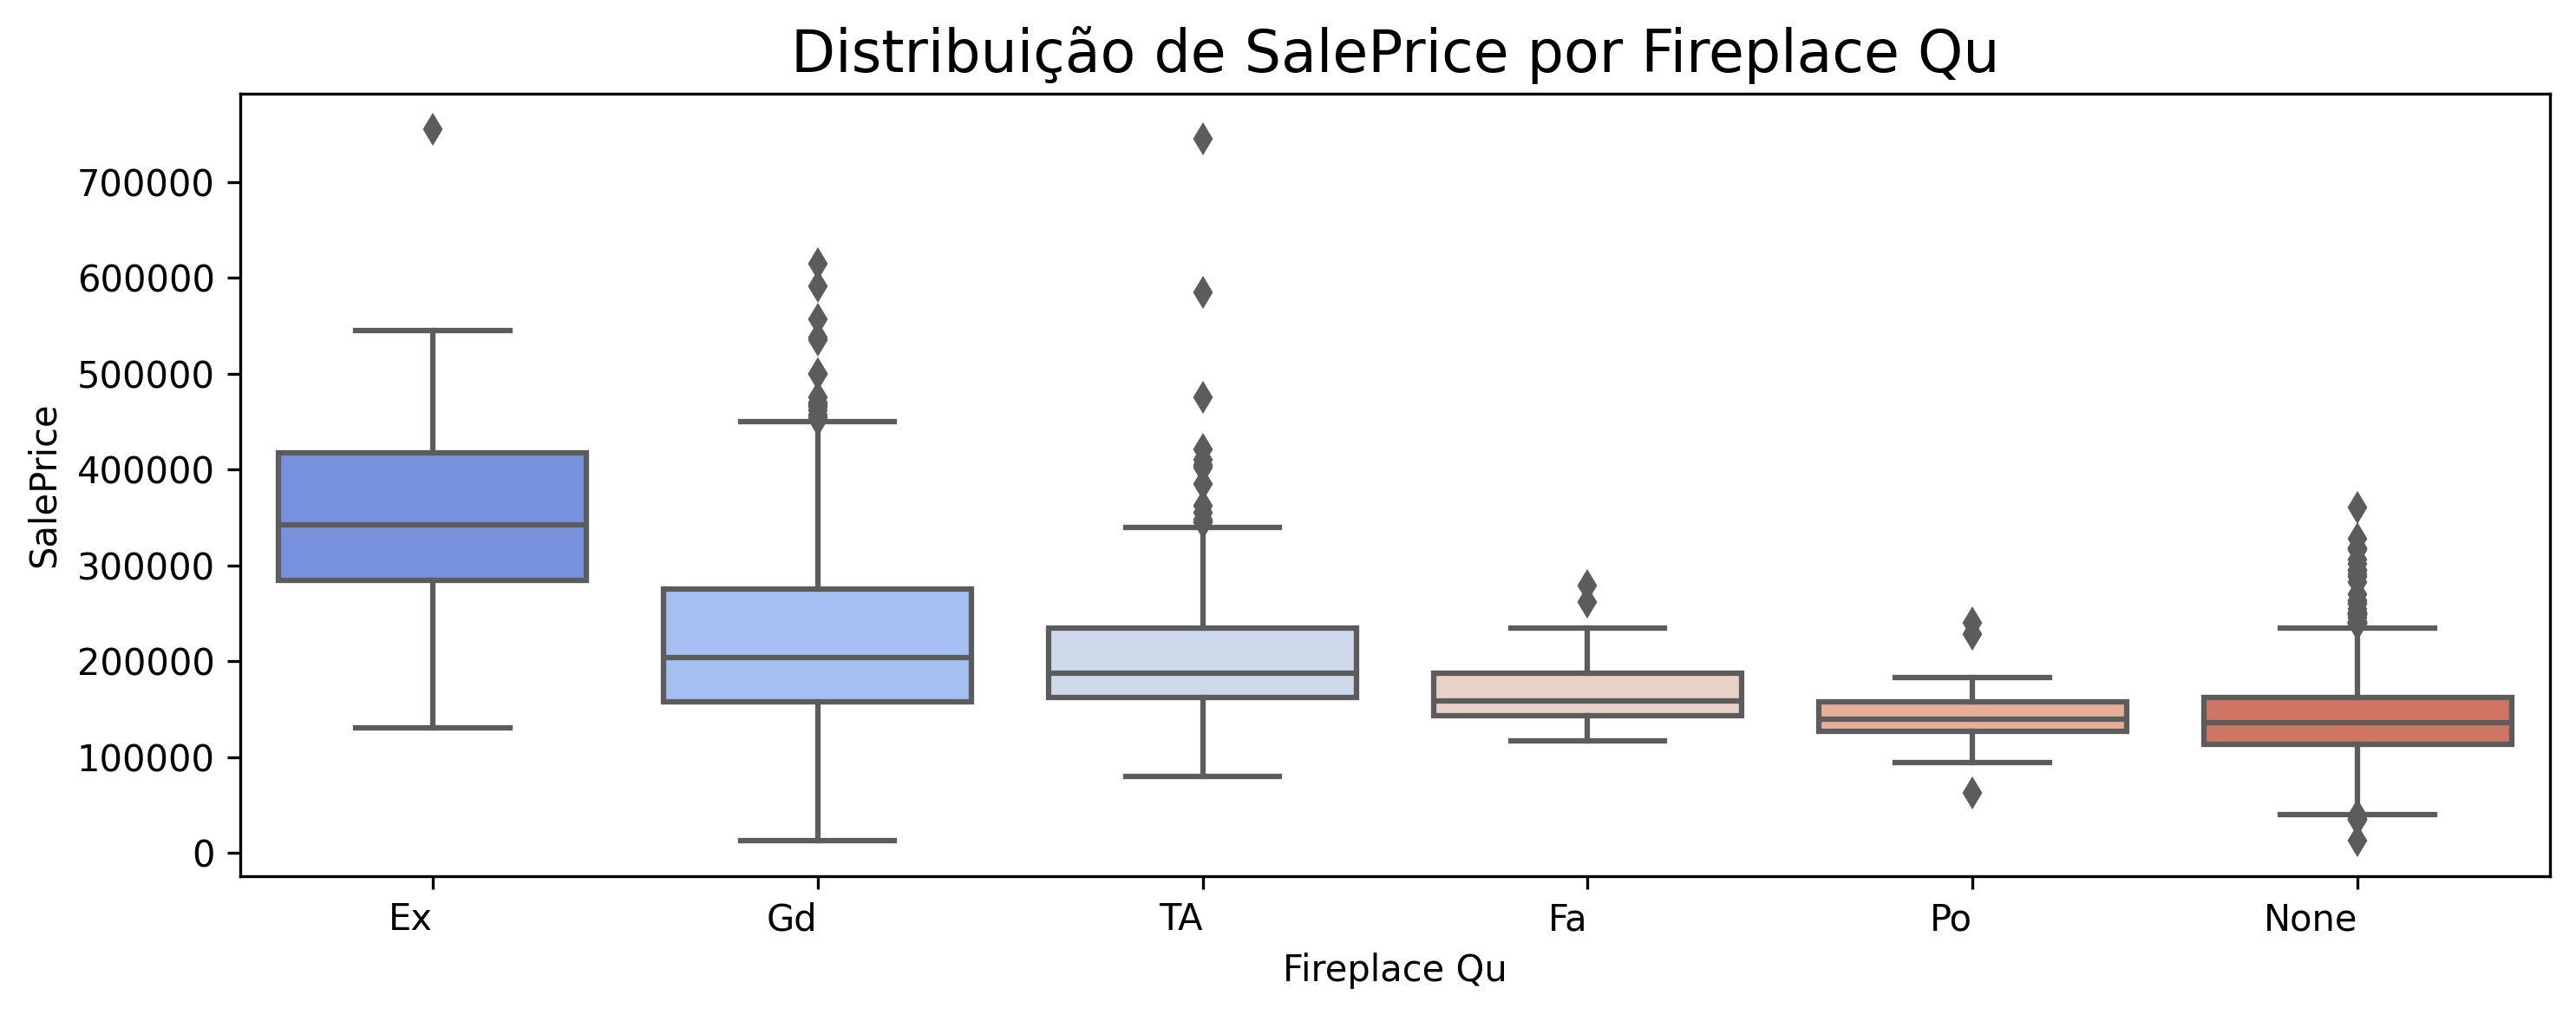

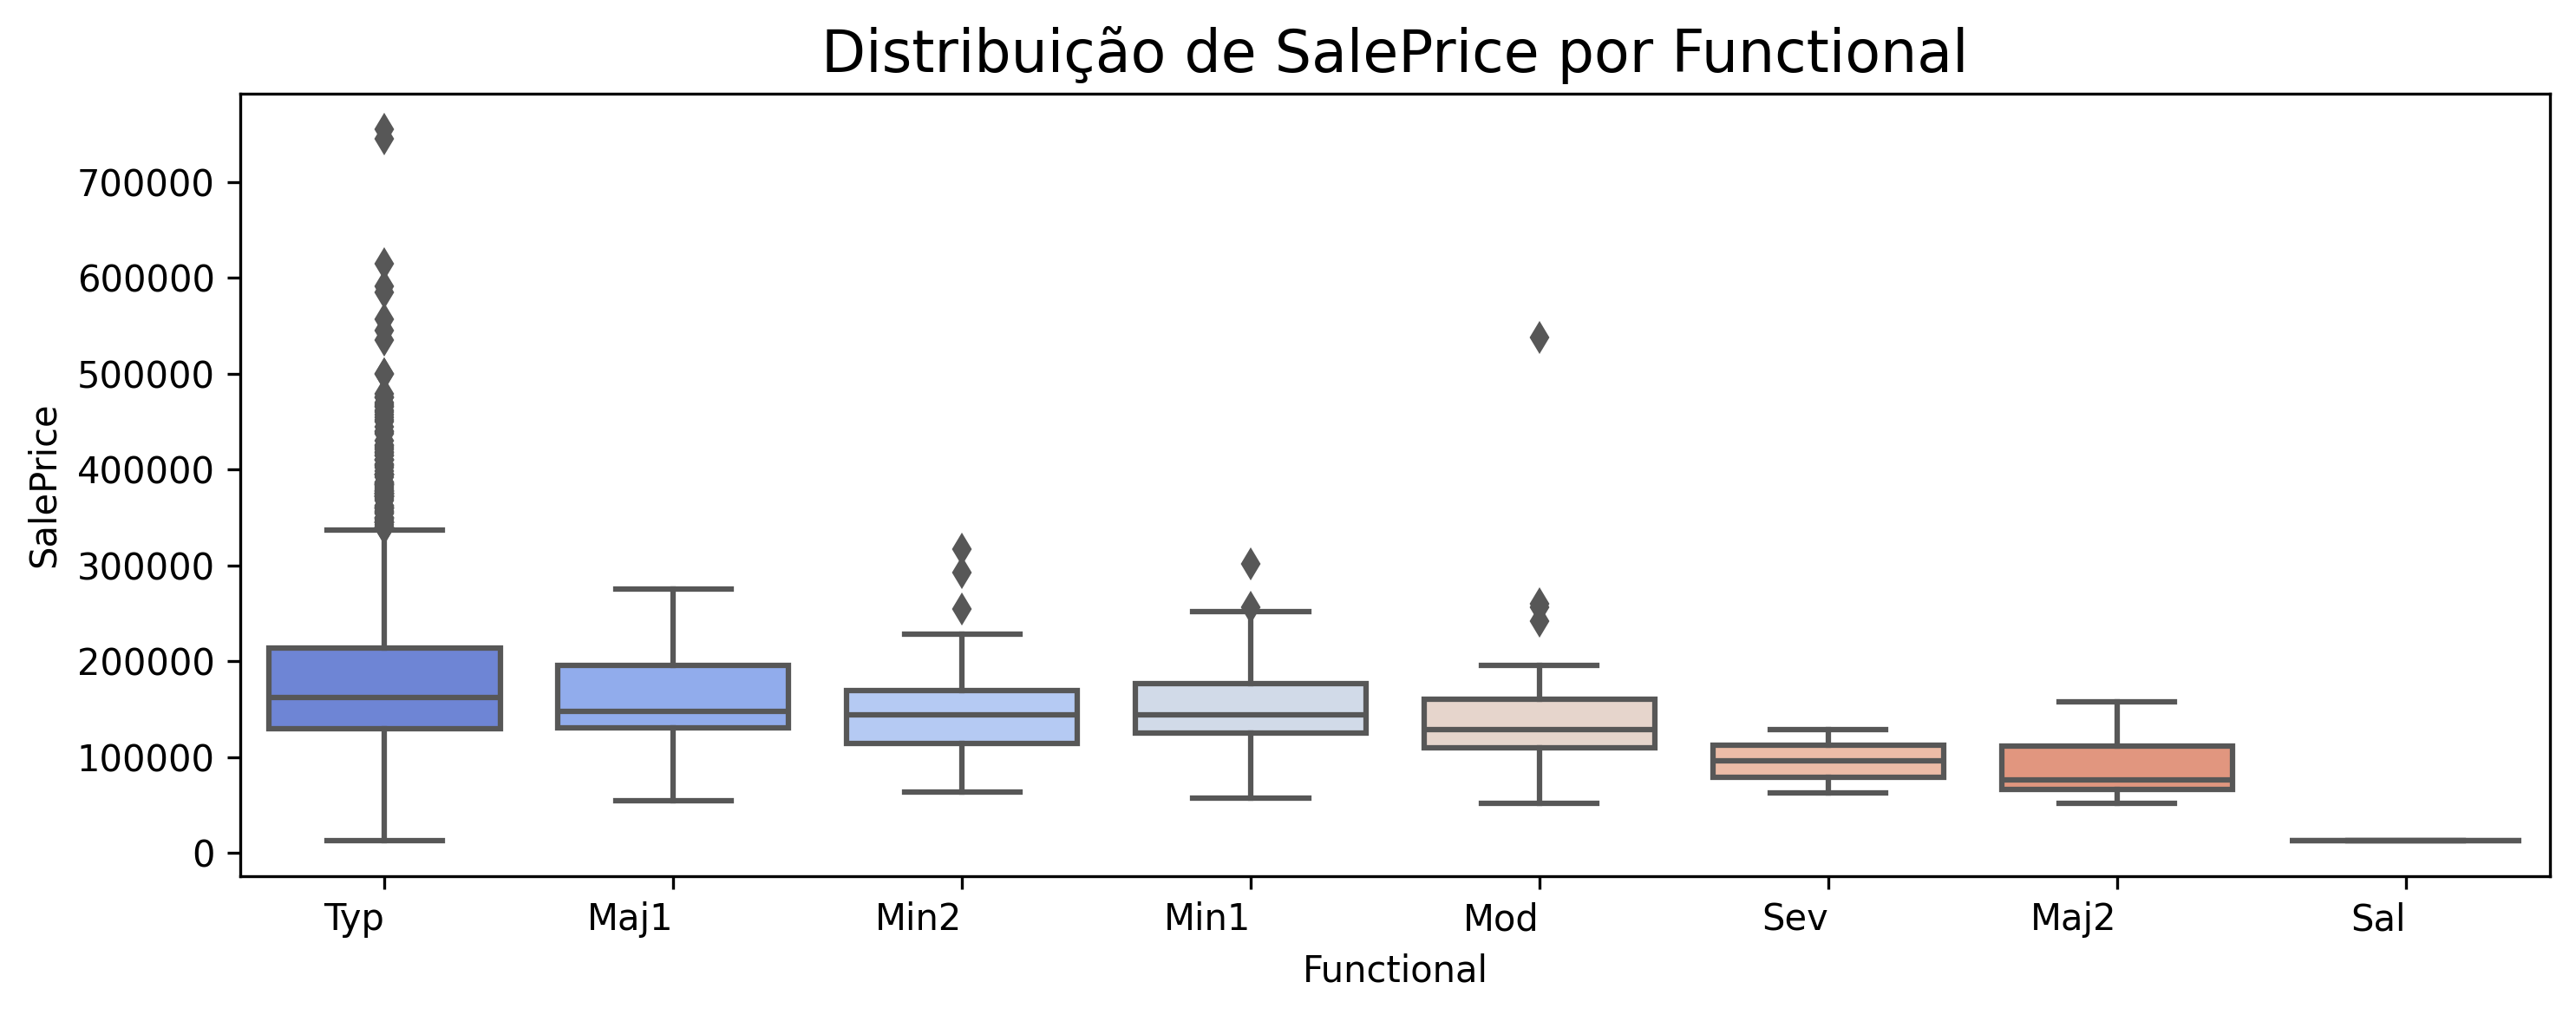

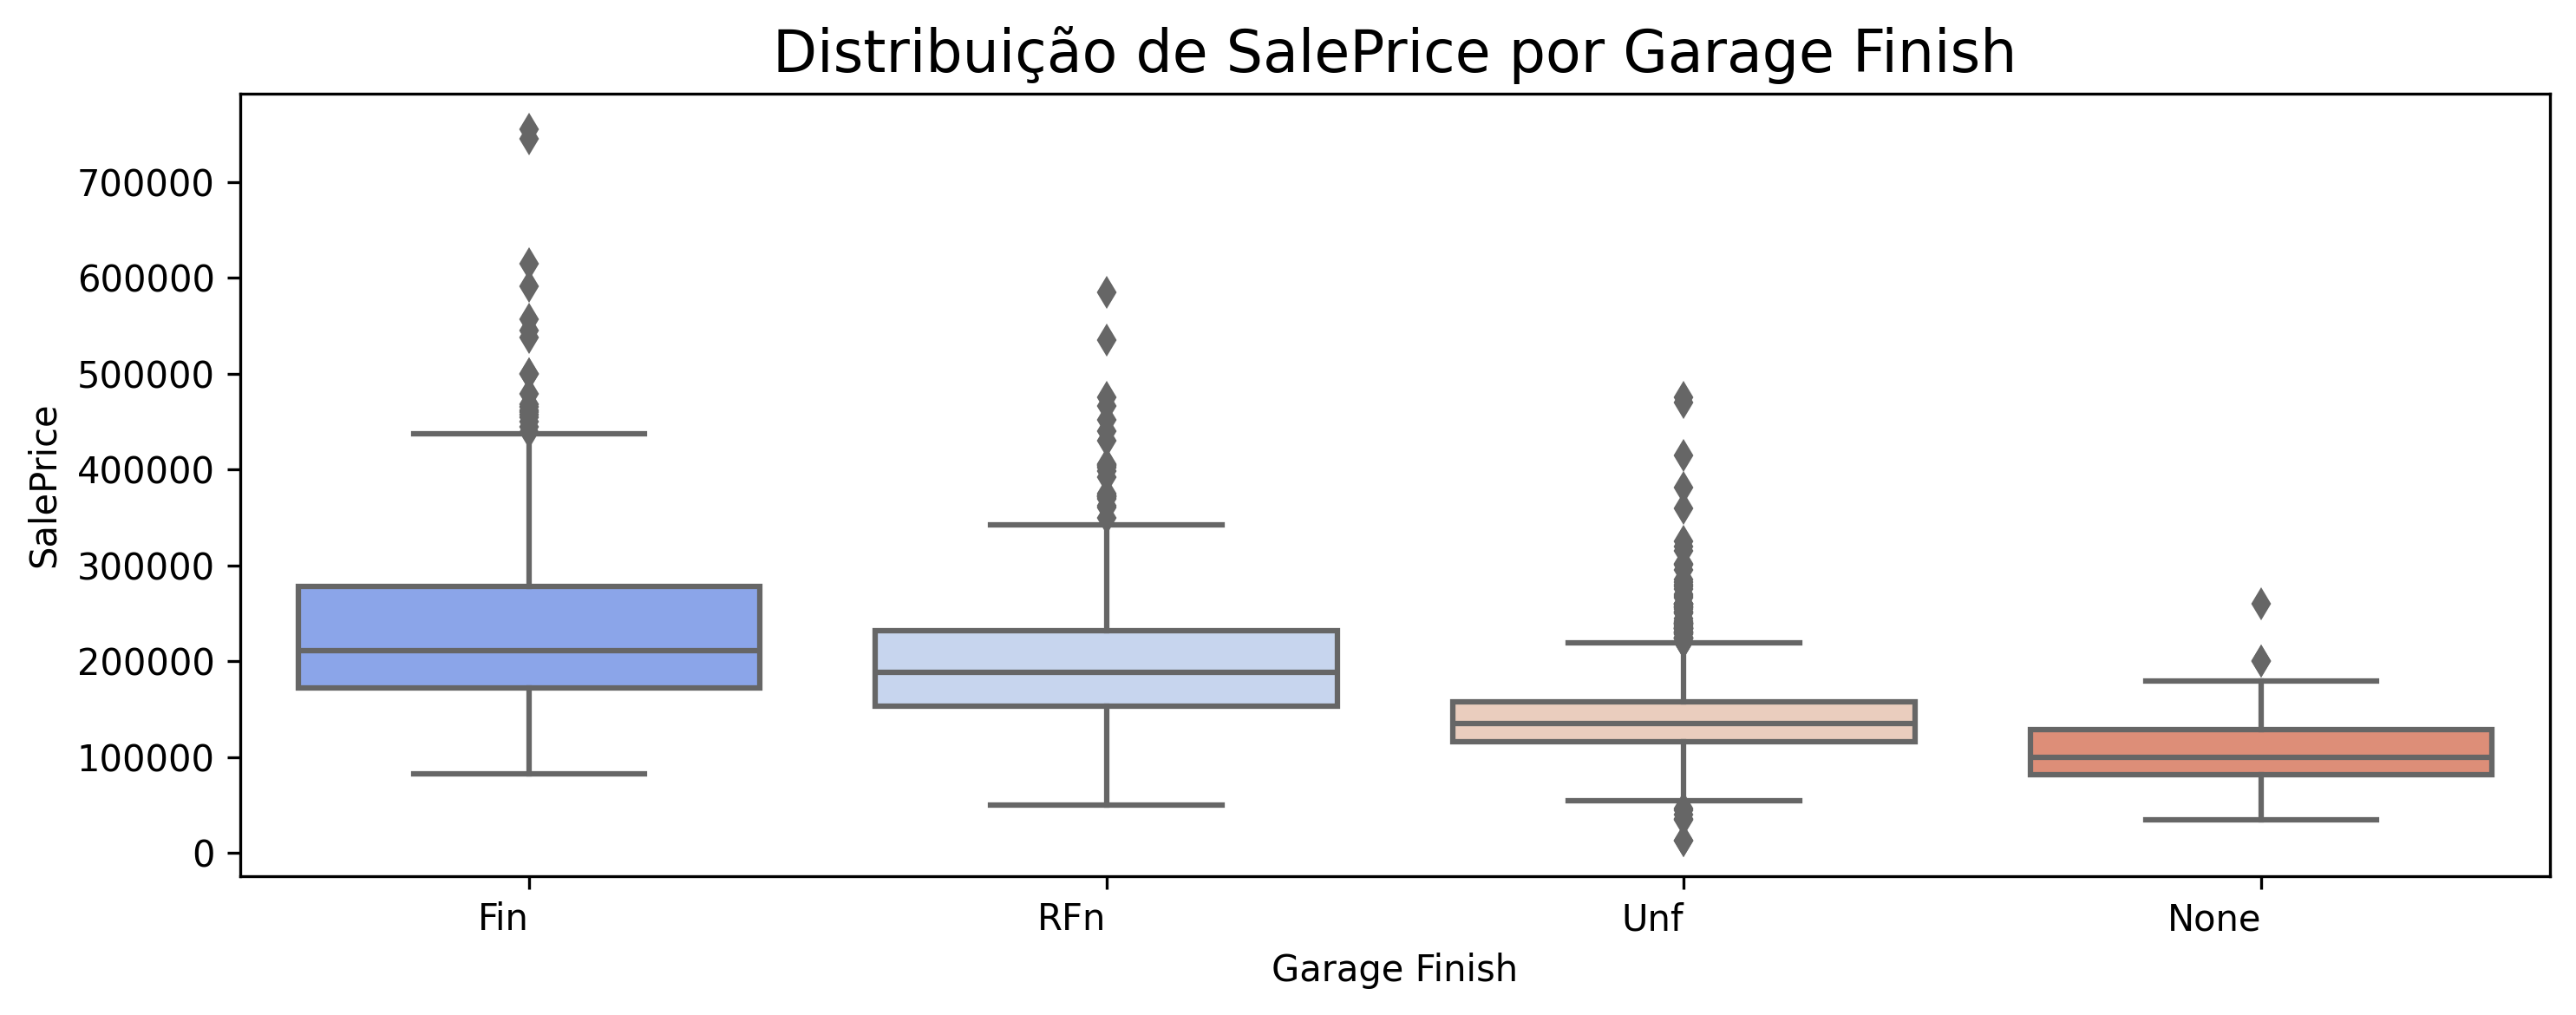

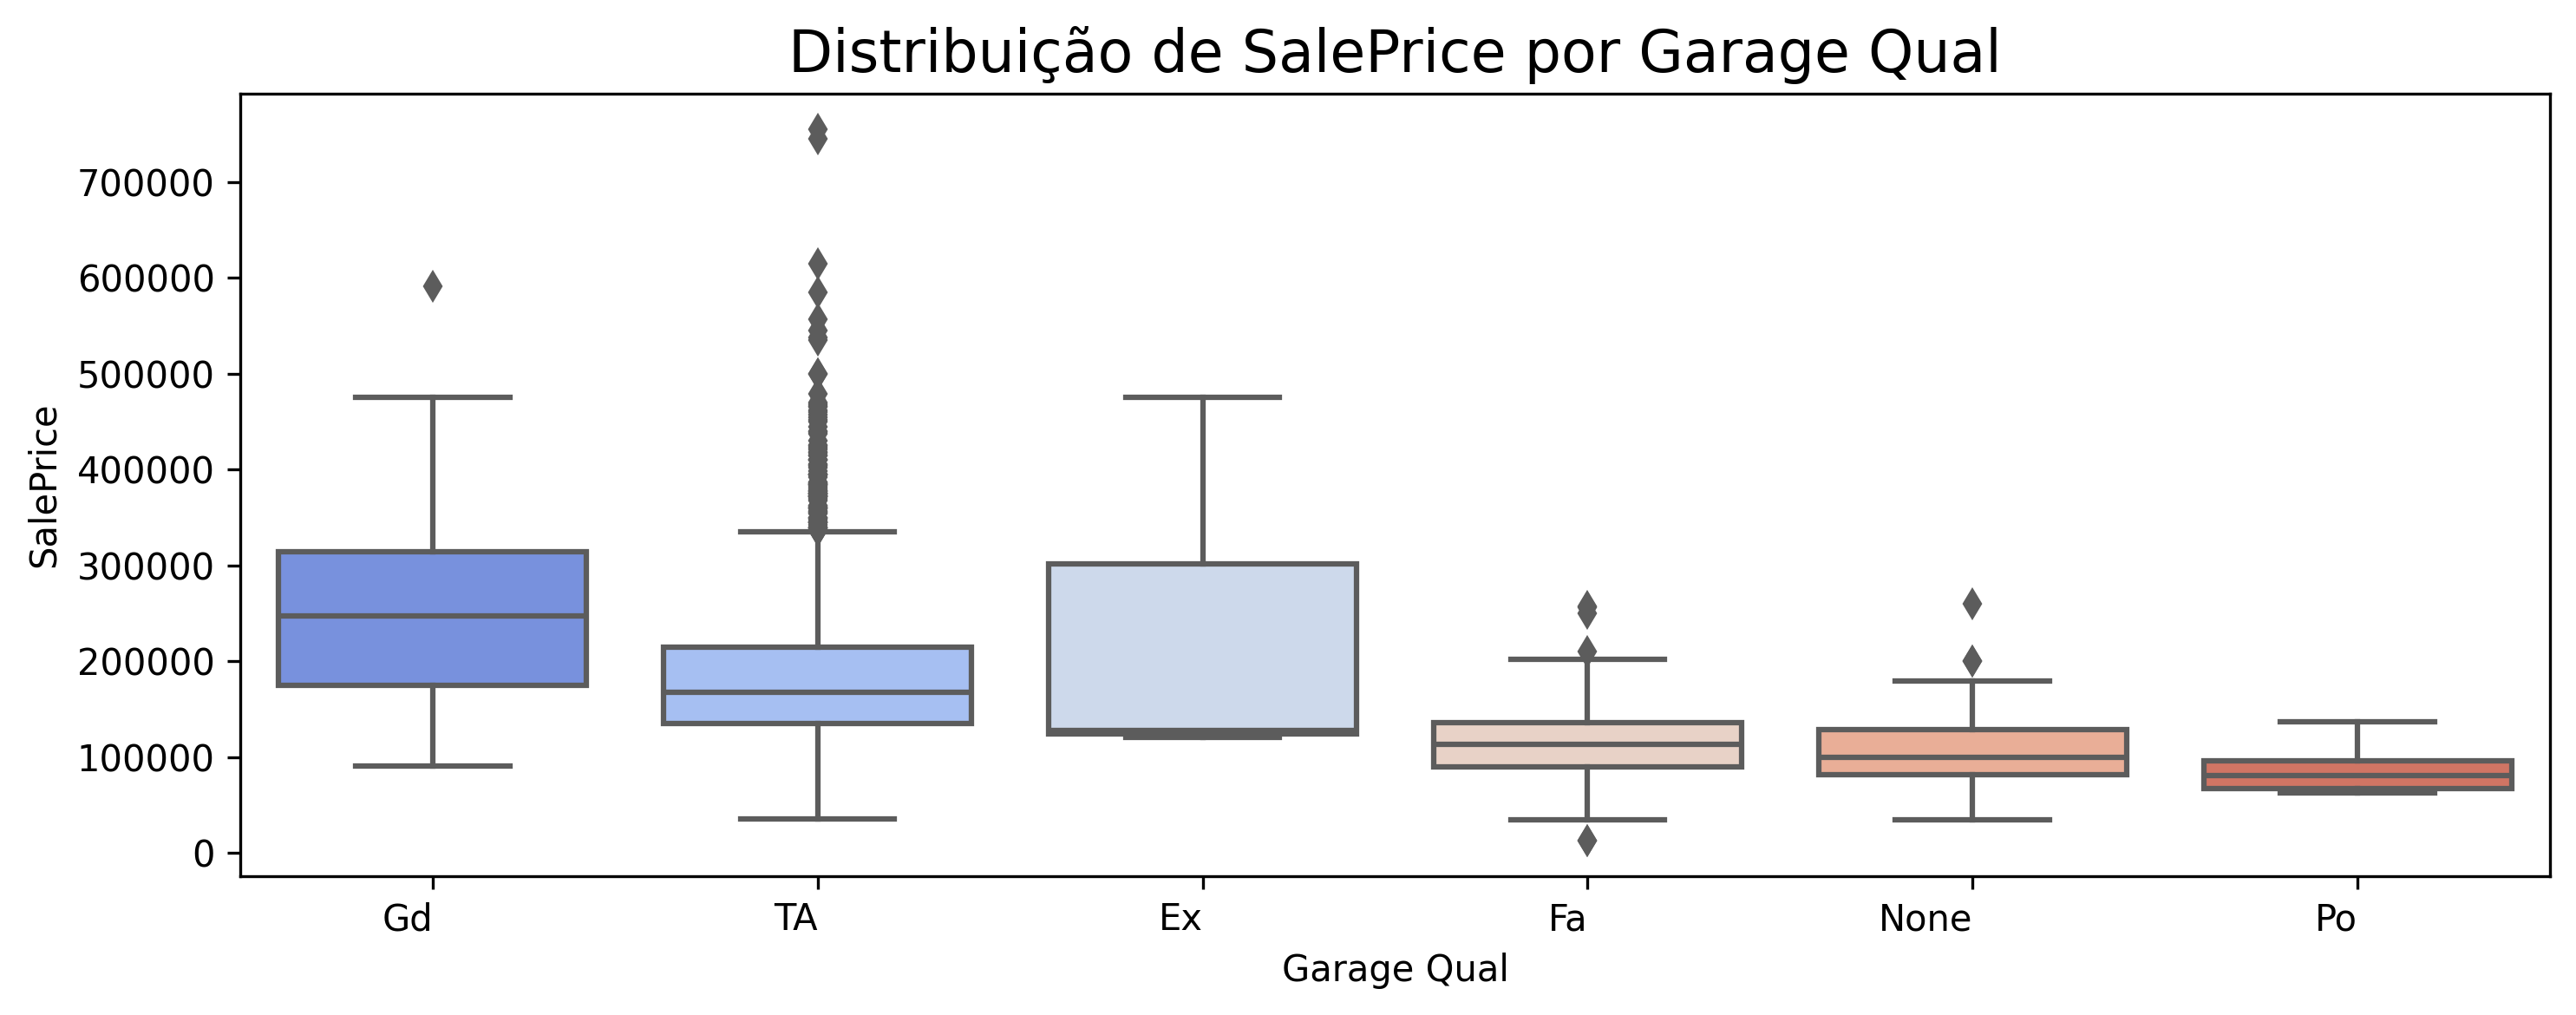

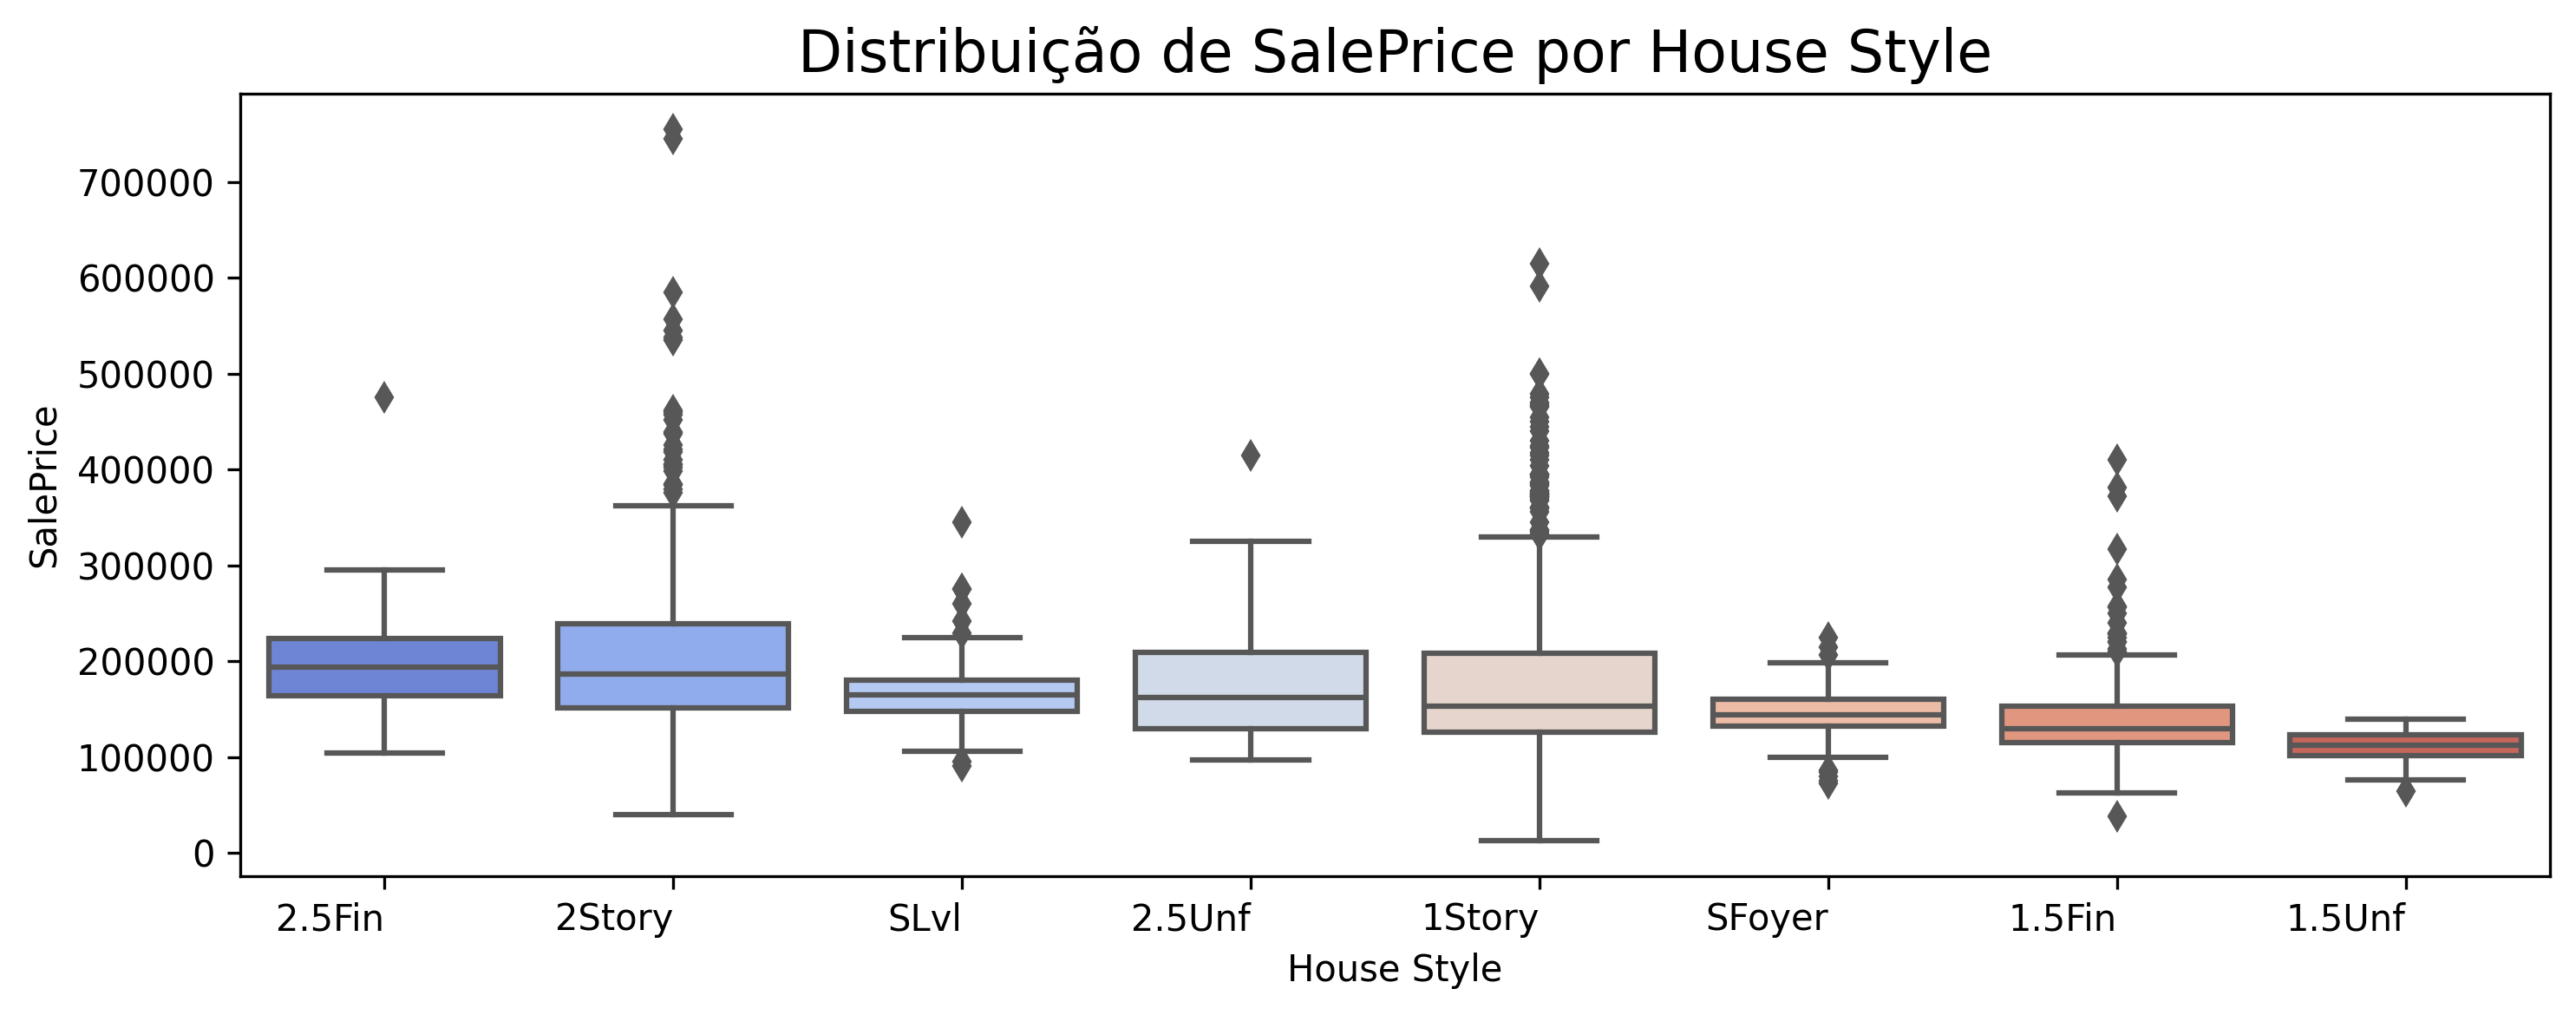

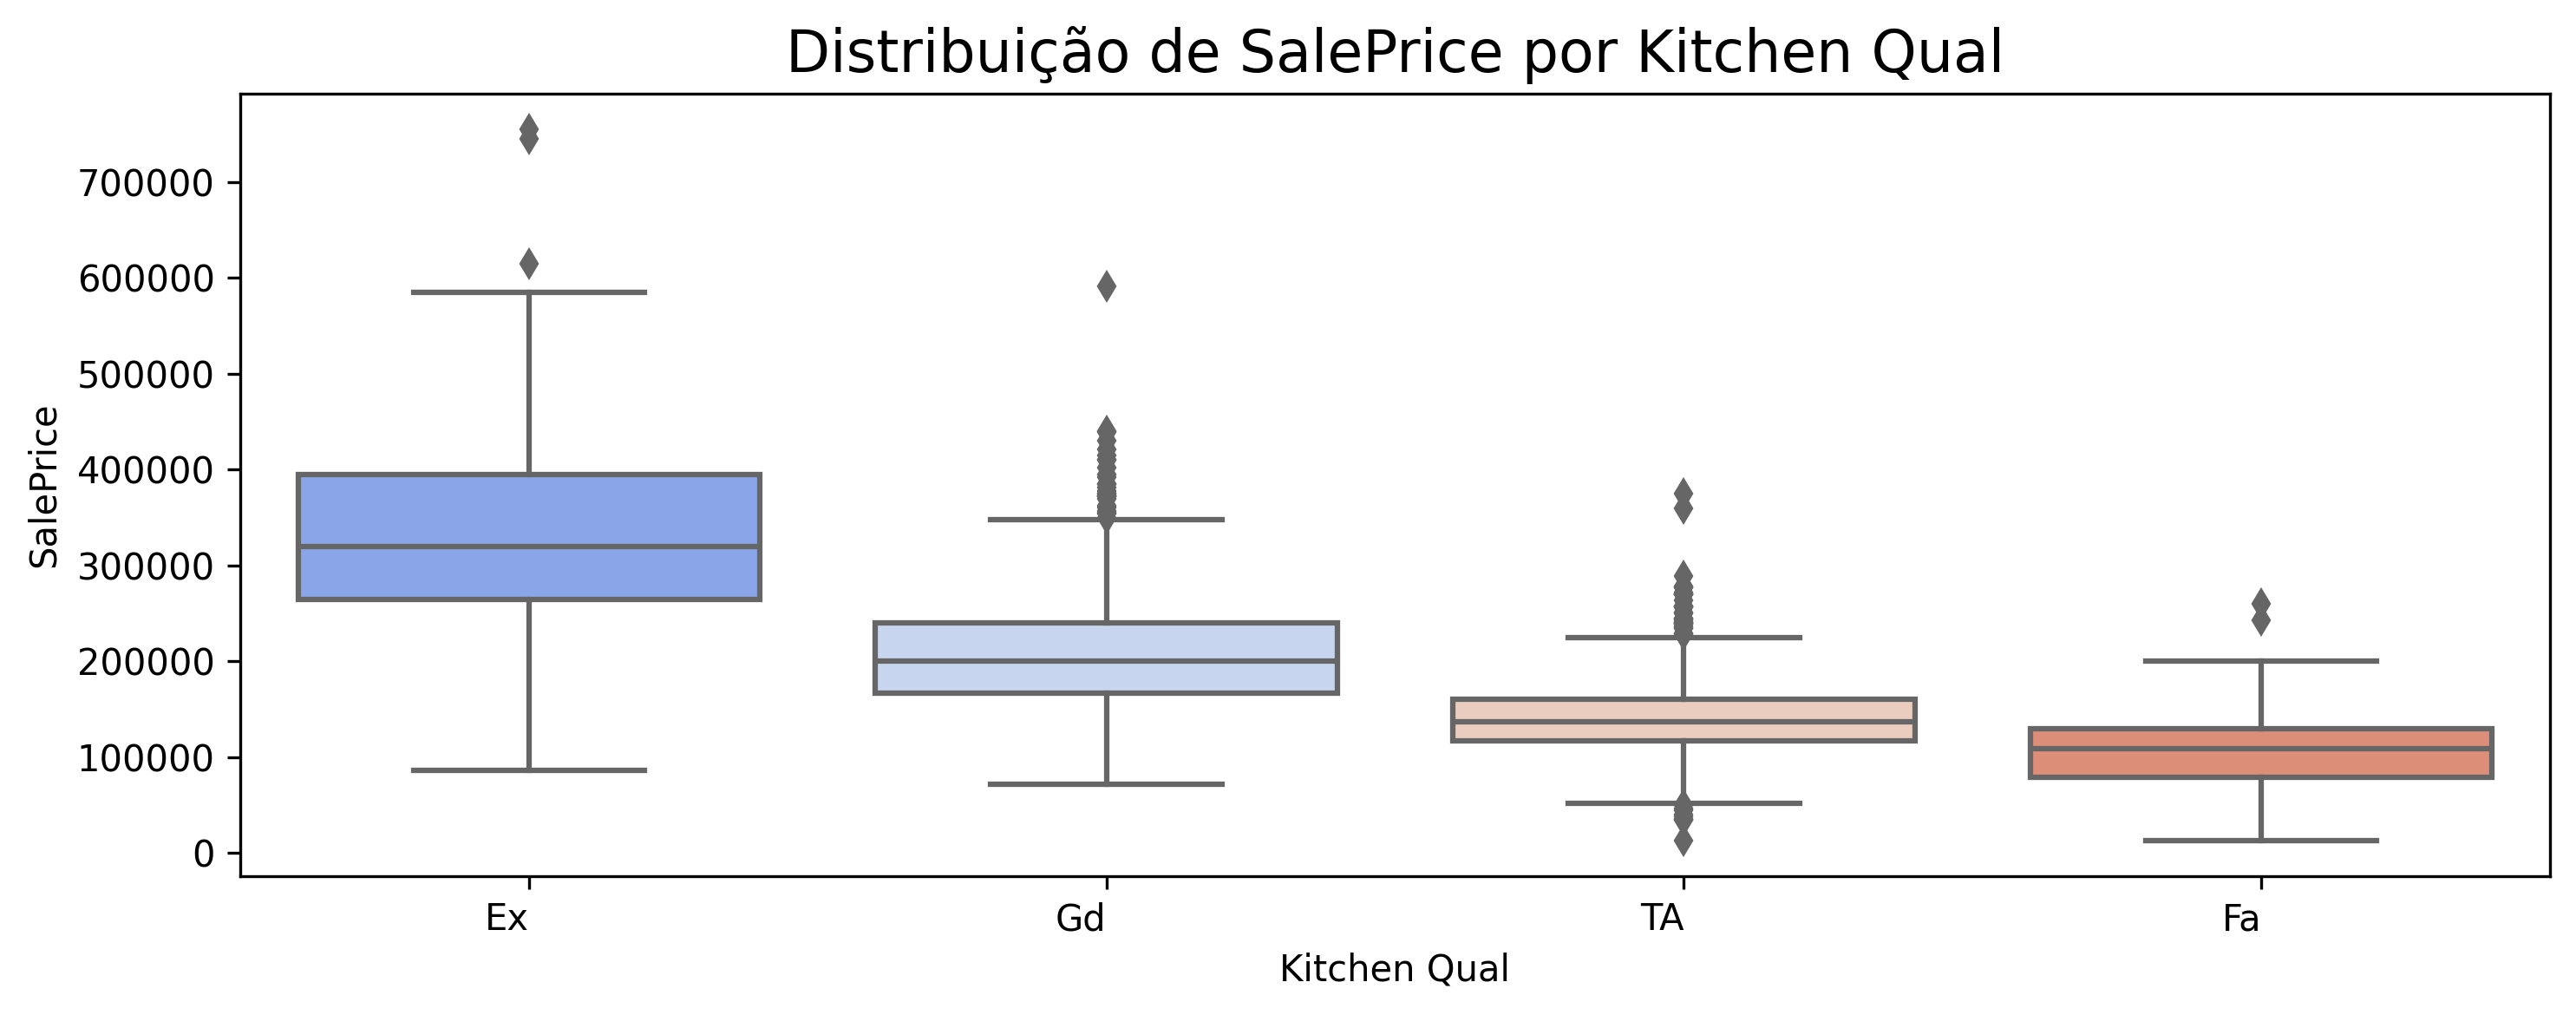

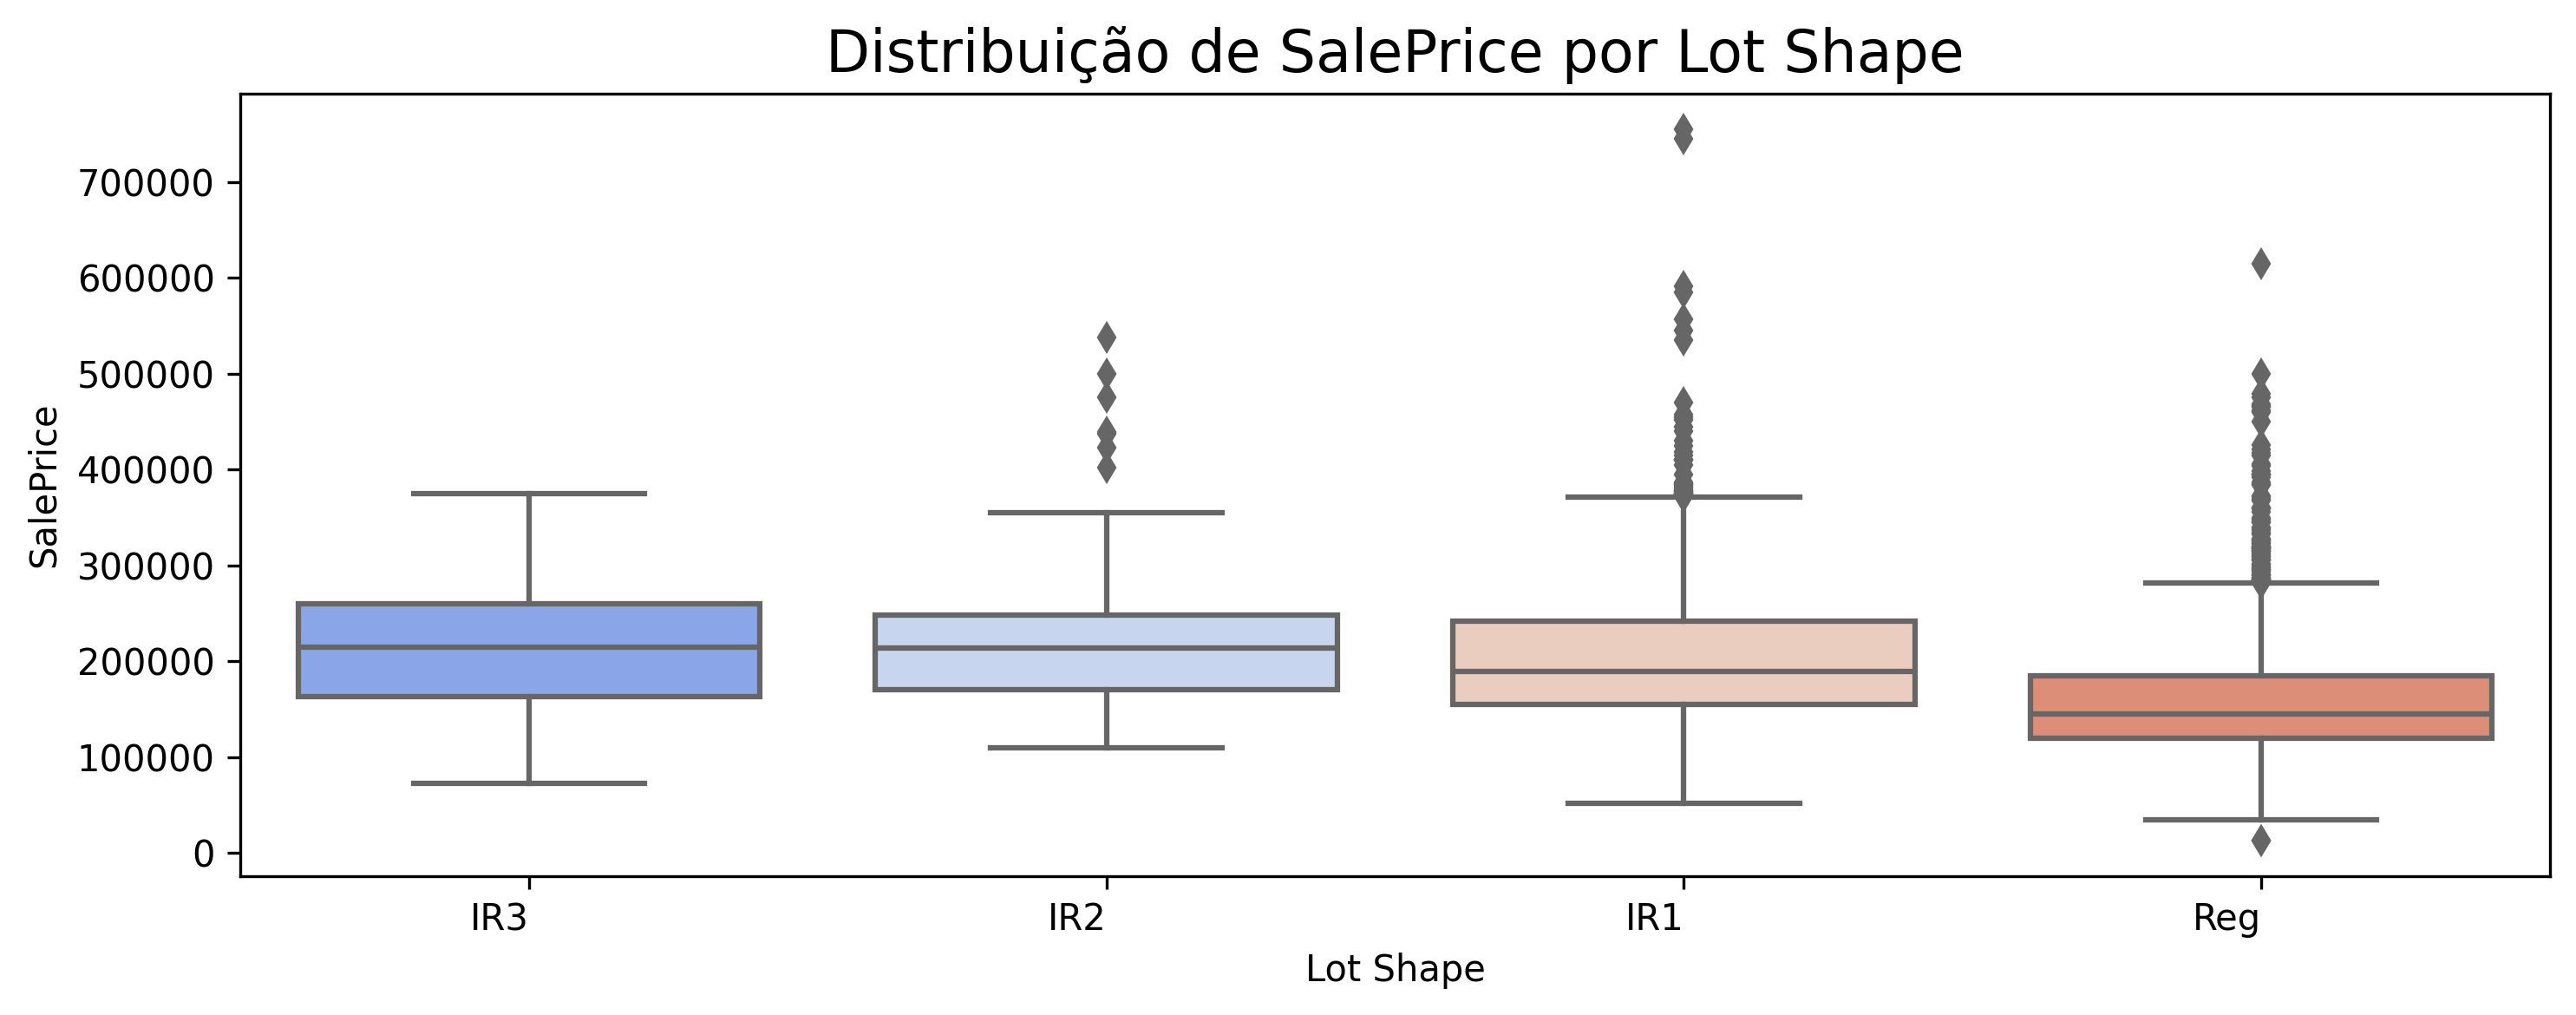

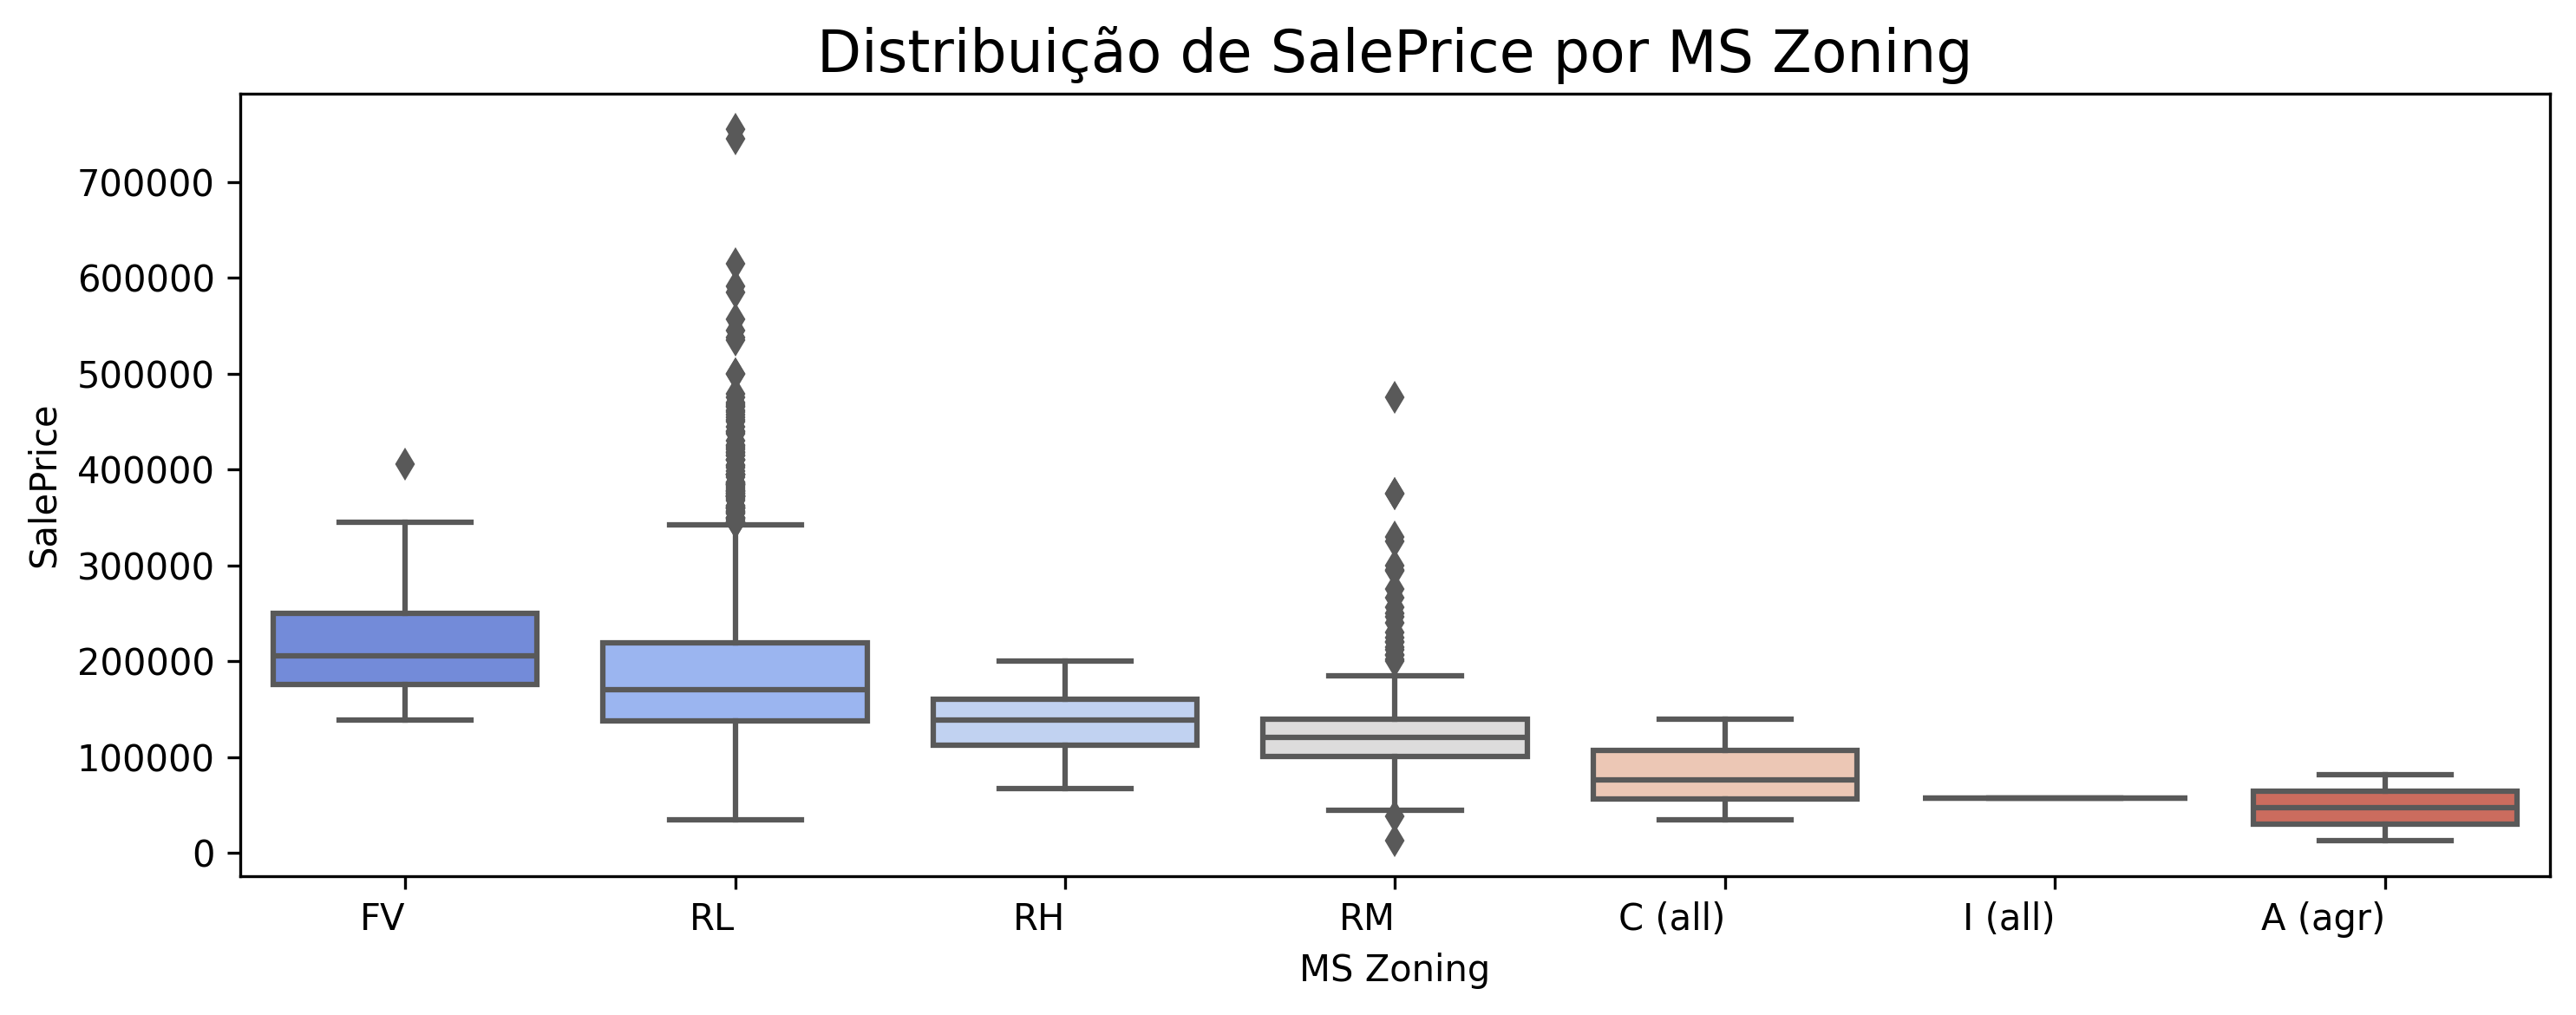

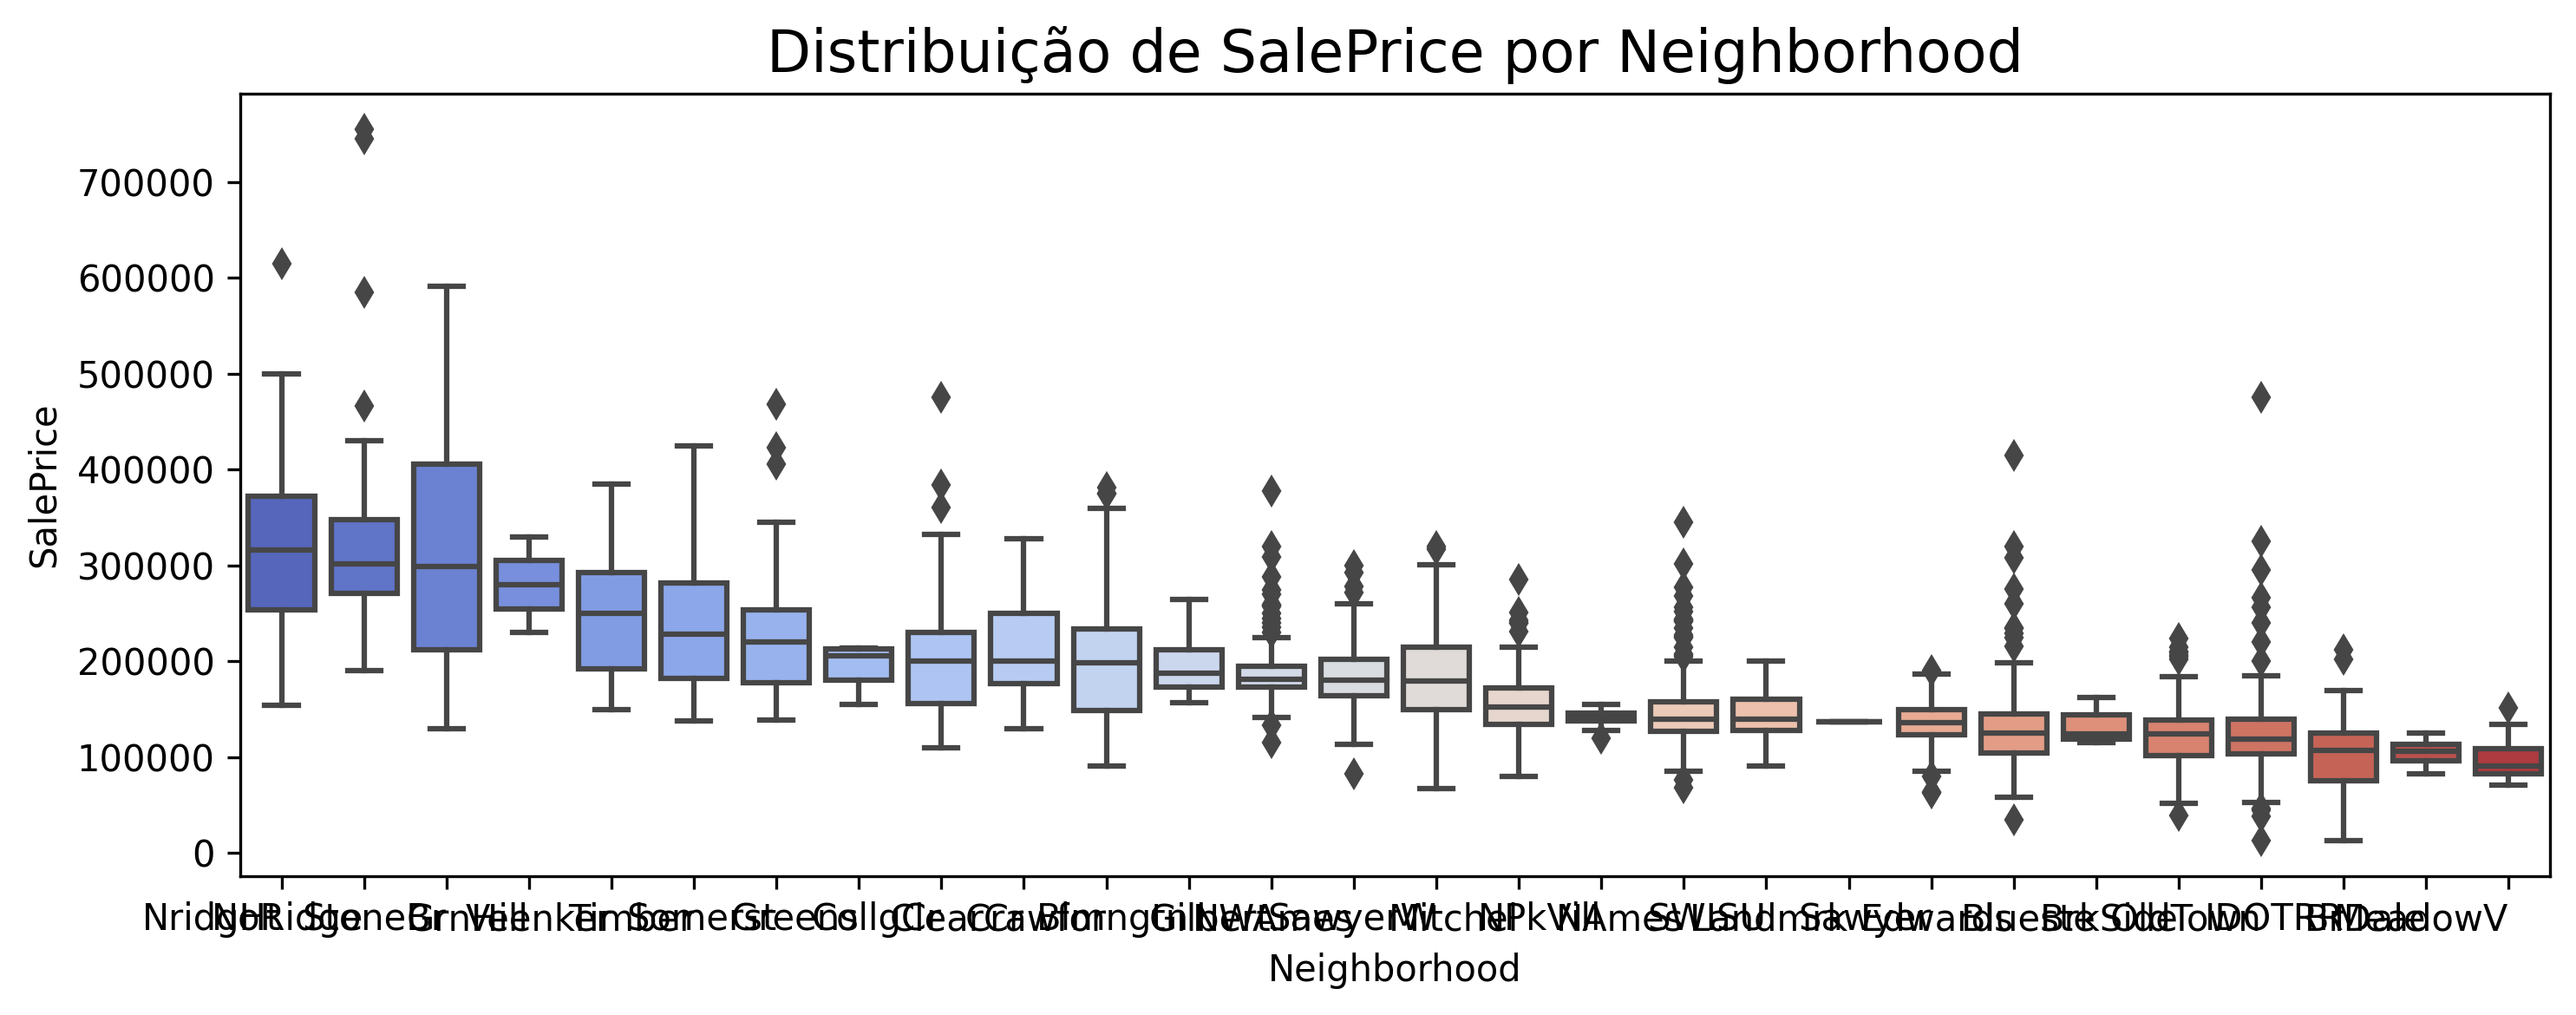

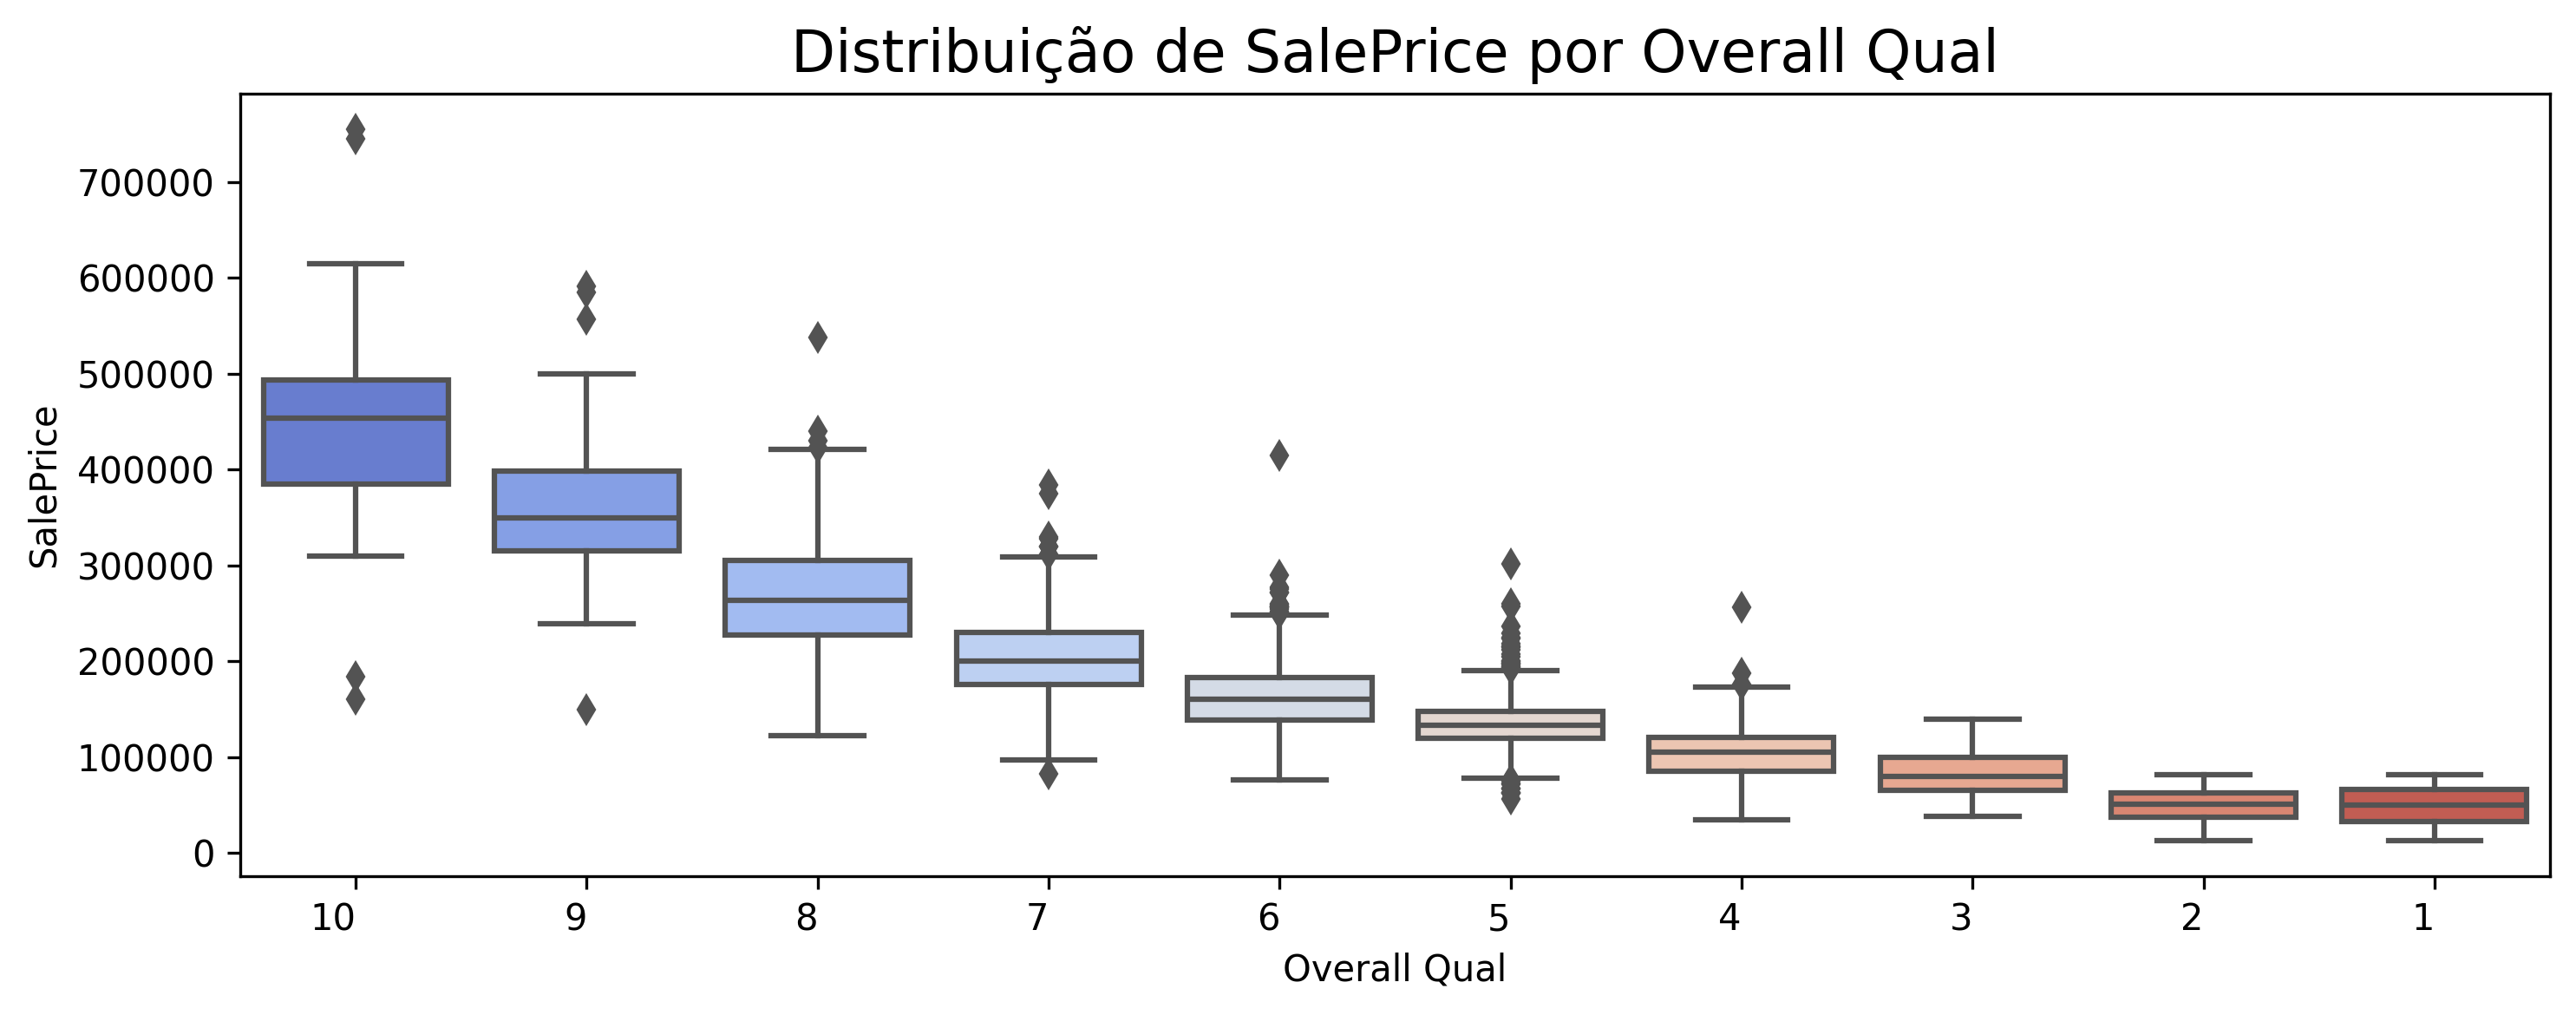

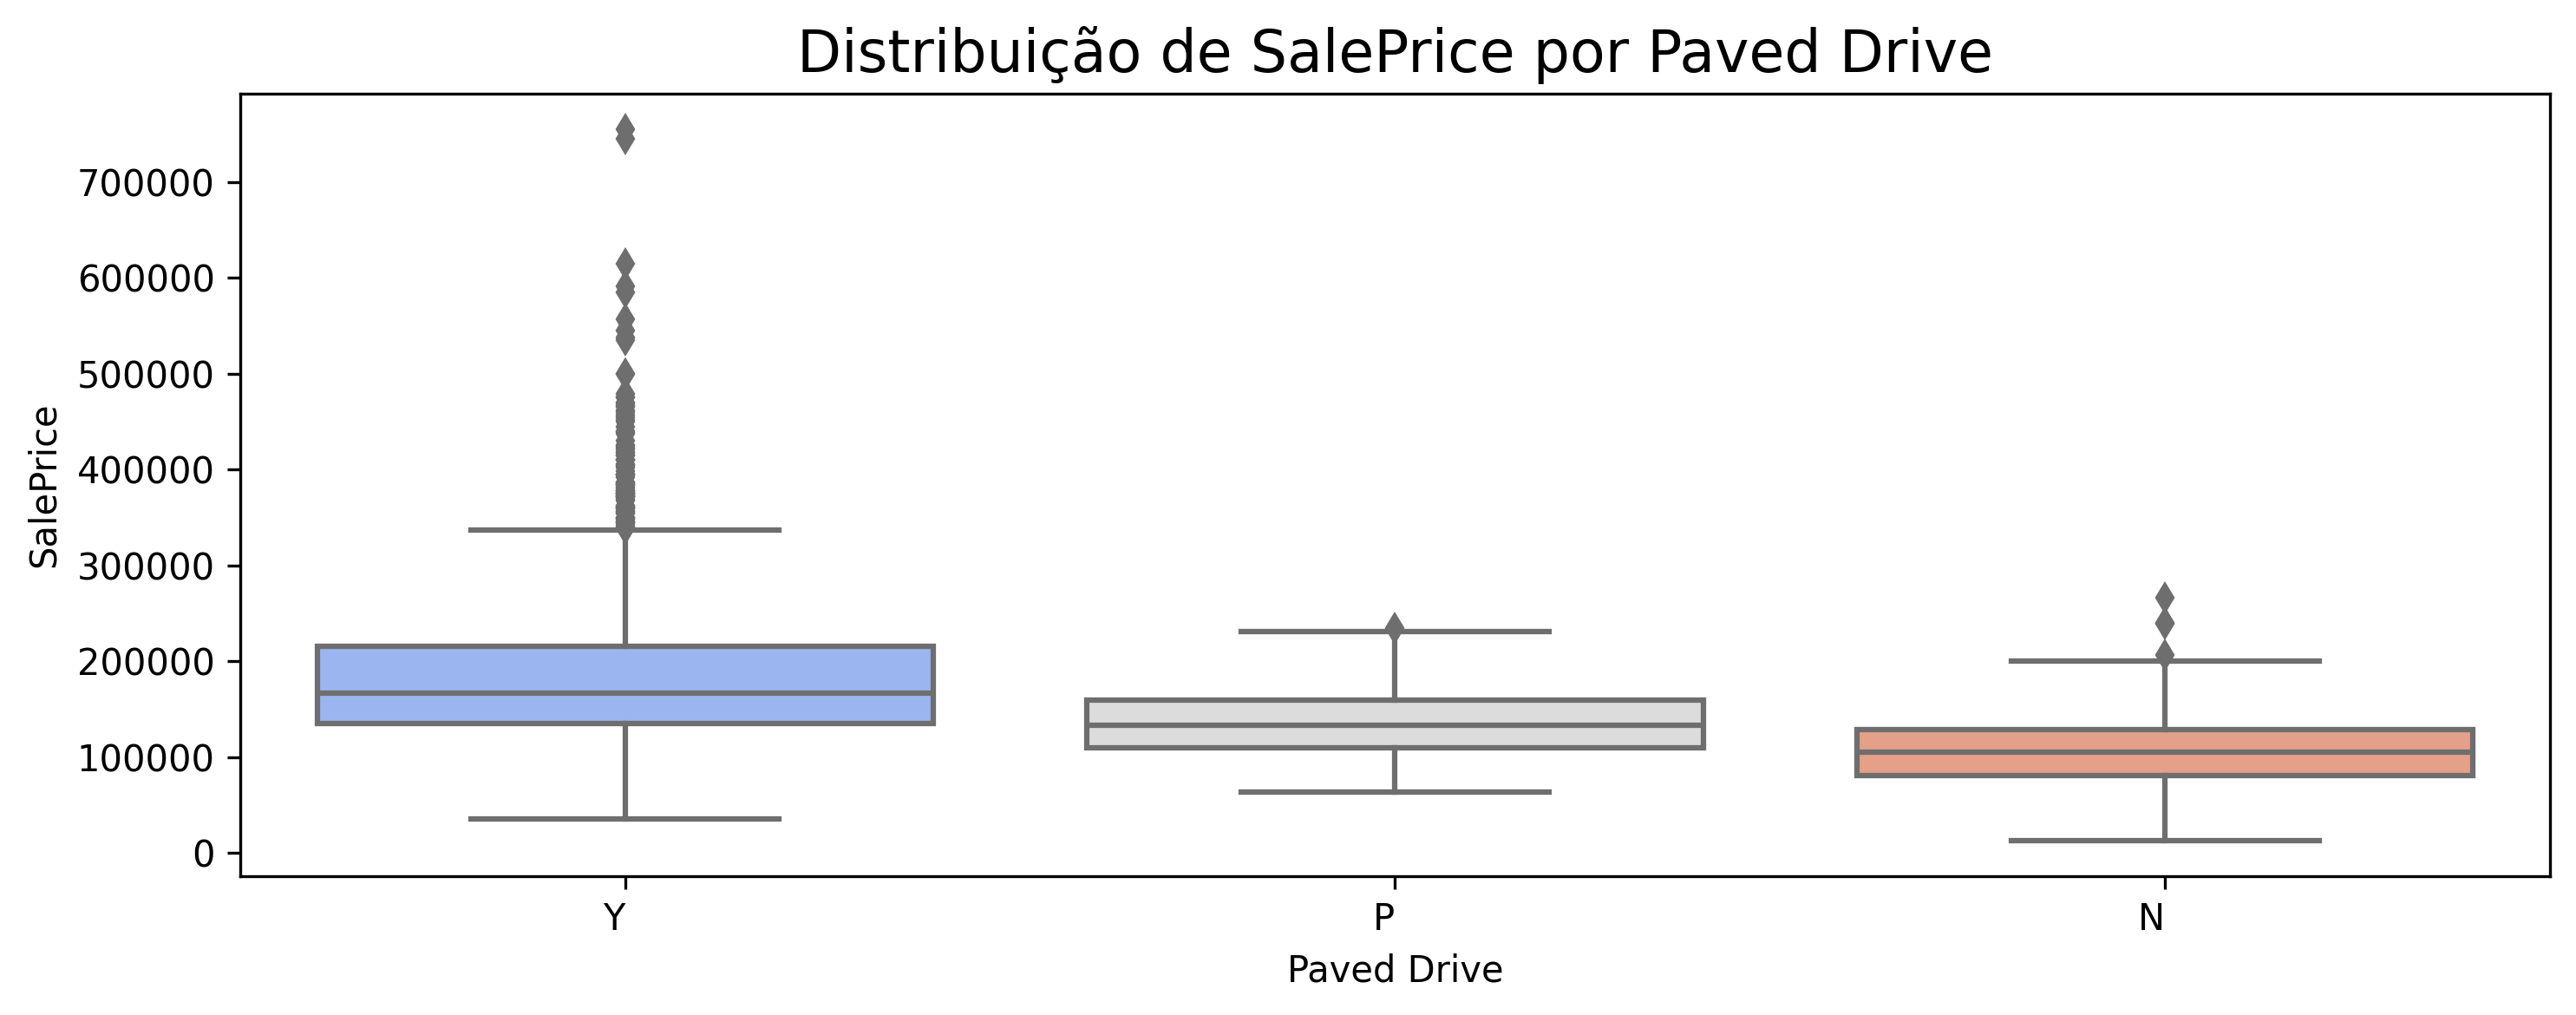

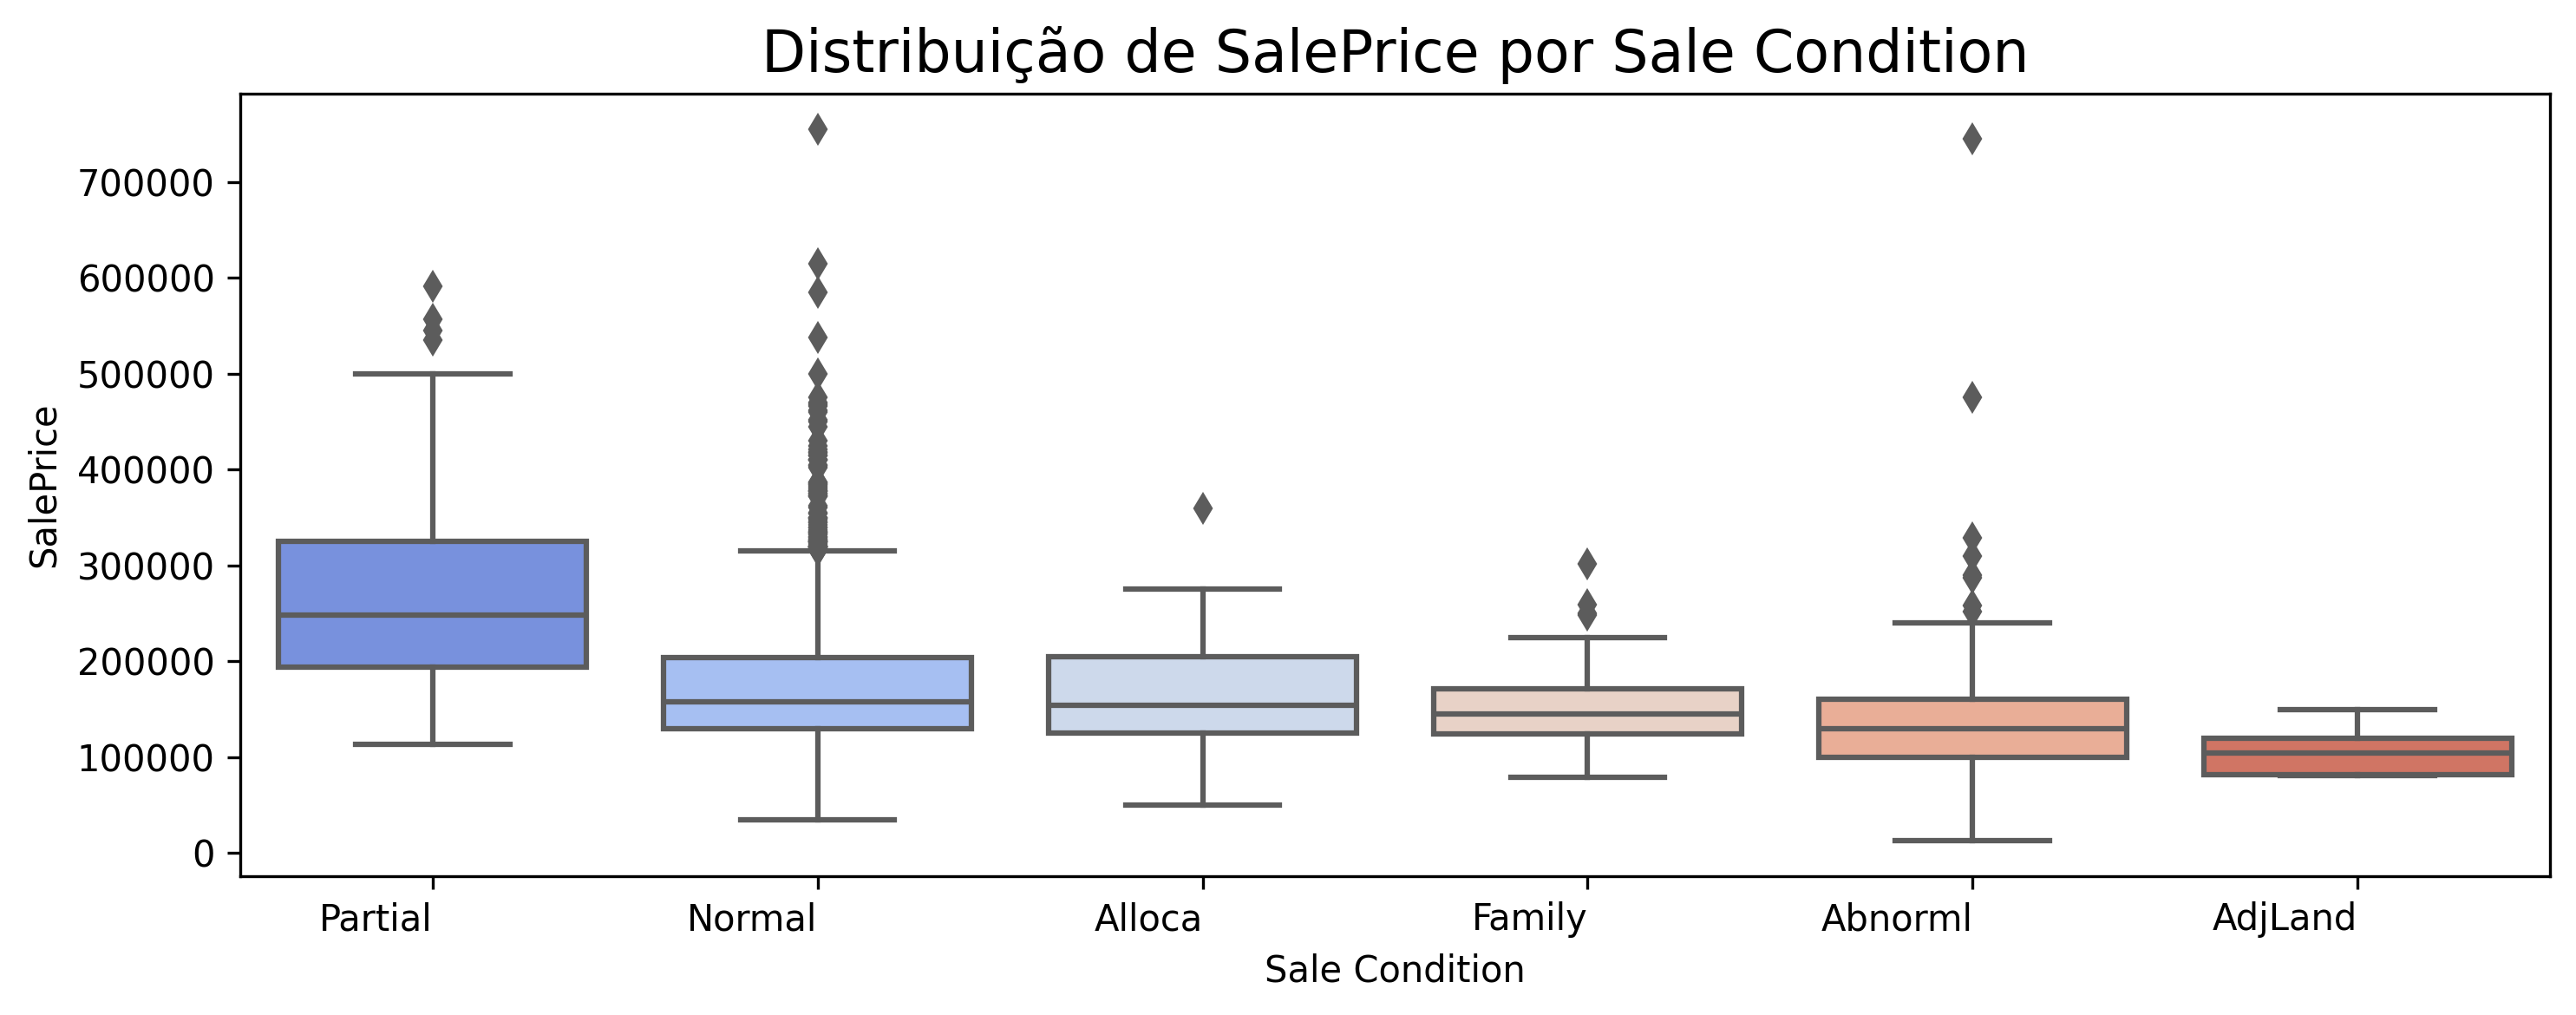

In [17]:
high_impact_cat = ['Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Fireplace Qu', 'Functional', 'Garage Finish', 'Garage Qual', 'House Style', 'Kitchen Qual', 'Lot Shape', 'MS Zoning', 'Neighborhood', 'Overall Qual', 'Paved Drive', 'Sale Condition']

for cat_var in high_impact_cat:
    plt.figure(figsize=(10, 4), dpi=300)
    order = train_df.groupby(cat_var)['SalePrice'].median().sort_values(ascending=False).index
    sns.boxplot(x=cat_var, y='SalePrice', data=train_df, order=order, palette="coolwarm")
    plt.xticks(rotation=0, ha='right')
    plt.title(f"Distribuição de SalePrice por {cat_var}", fontsize=16)
    plt.ylabel("SalePrice")
    plt.xlabel(cat_var)
    plt.tight_layout()
    plt.show()

Seguindo a estratégia de observação anteriormente descrita, em que as medianas dos preços variam consideravelmente entre as distribuições de cada categoria de cada variável, decidi por selecionar as 10 variáveis que mais parecem influenciar na variável alvo, listadas abaixo.

In [18]:
categorical_candidates = ['Overall Qual', 'Neighborhood', 'Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'Garage Finish', 'Garage Qual', 'House Style', 'Sale Condition', 'MS Zoning']
categorical_candidates

['Overall Qual',
 'Neighborhood',
 'Exter Qual',
 'Kitchen Qual',
 'Bsmt Qual',
 'Garage Finish',
 'Garage Qual',
 'House Style',
 'Sale Condition',
 'MS Zoning']

Filtro então o dataset com as colunas candidatas ao treinamento dos modelos de predição.

In [19]:
train_df = train_df[numeric_great_corr_varrs + categorical_candidates + ['SalePrice']]
train_df.sample(5)

,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Year Built,Full Bath,Year Remod/Add,Mas Vnr Area,...,Neighborhood,Exter Qual,Kitchen Qual,Bsmt Qual,Garage Finish,Garage Qual,House Style,Sale Condition,MS Zoning,SalePrice
219,5,1056,1.0,304.0,1056.0,1056,1968,1,1968,0.0,...,NAmes,TA,TA,TA,Unf,TA,1Story,Normal,RL,142000
1524,6,1560,2.0,400.0,684.0,684,2005,2,2005,0.0,...,Gilbert,Gd,Gd,Gd,Fin,TA,2Story,Normal,RL,174000
603,8,1629,3.0,808.0,1616.0,1629,2002,2,2003,236.0,...,Timber,Gd,Gd,Gd,Fin,TA,1Story,Normal,RL,270000
1915,6,1442,2.0,615.0,1442.0,1442,1970,2,1970,571.0,...,NWAmes,TA,TA,TA,RFn,TA,1Story,Normal,RL,185000
2248,5,890,1.0,308.0,890.0,890,1968,1,1968,0.0,...,Sawyer,TA,TA,TA,Unf,TA,1Story,Normal,RL,115000


O próximo passo é substituir os outliers das variáveis numéricas. Para isso, utilizarei o método com z-score.

O Z-Score também é chamado de pontuação padrão. Essa pontuação mede a distância entre um ponto de dados e a média, em termos de desvios-padrão. Se o Z-Score exceder um limite determinado (geralmente 3), o ponto de dados é considerado um valor atípico.

Para decidir quais variáveis terão os outliers substituídos, estão exibidos abaixos os boxplots de cada variável numérica.

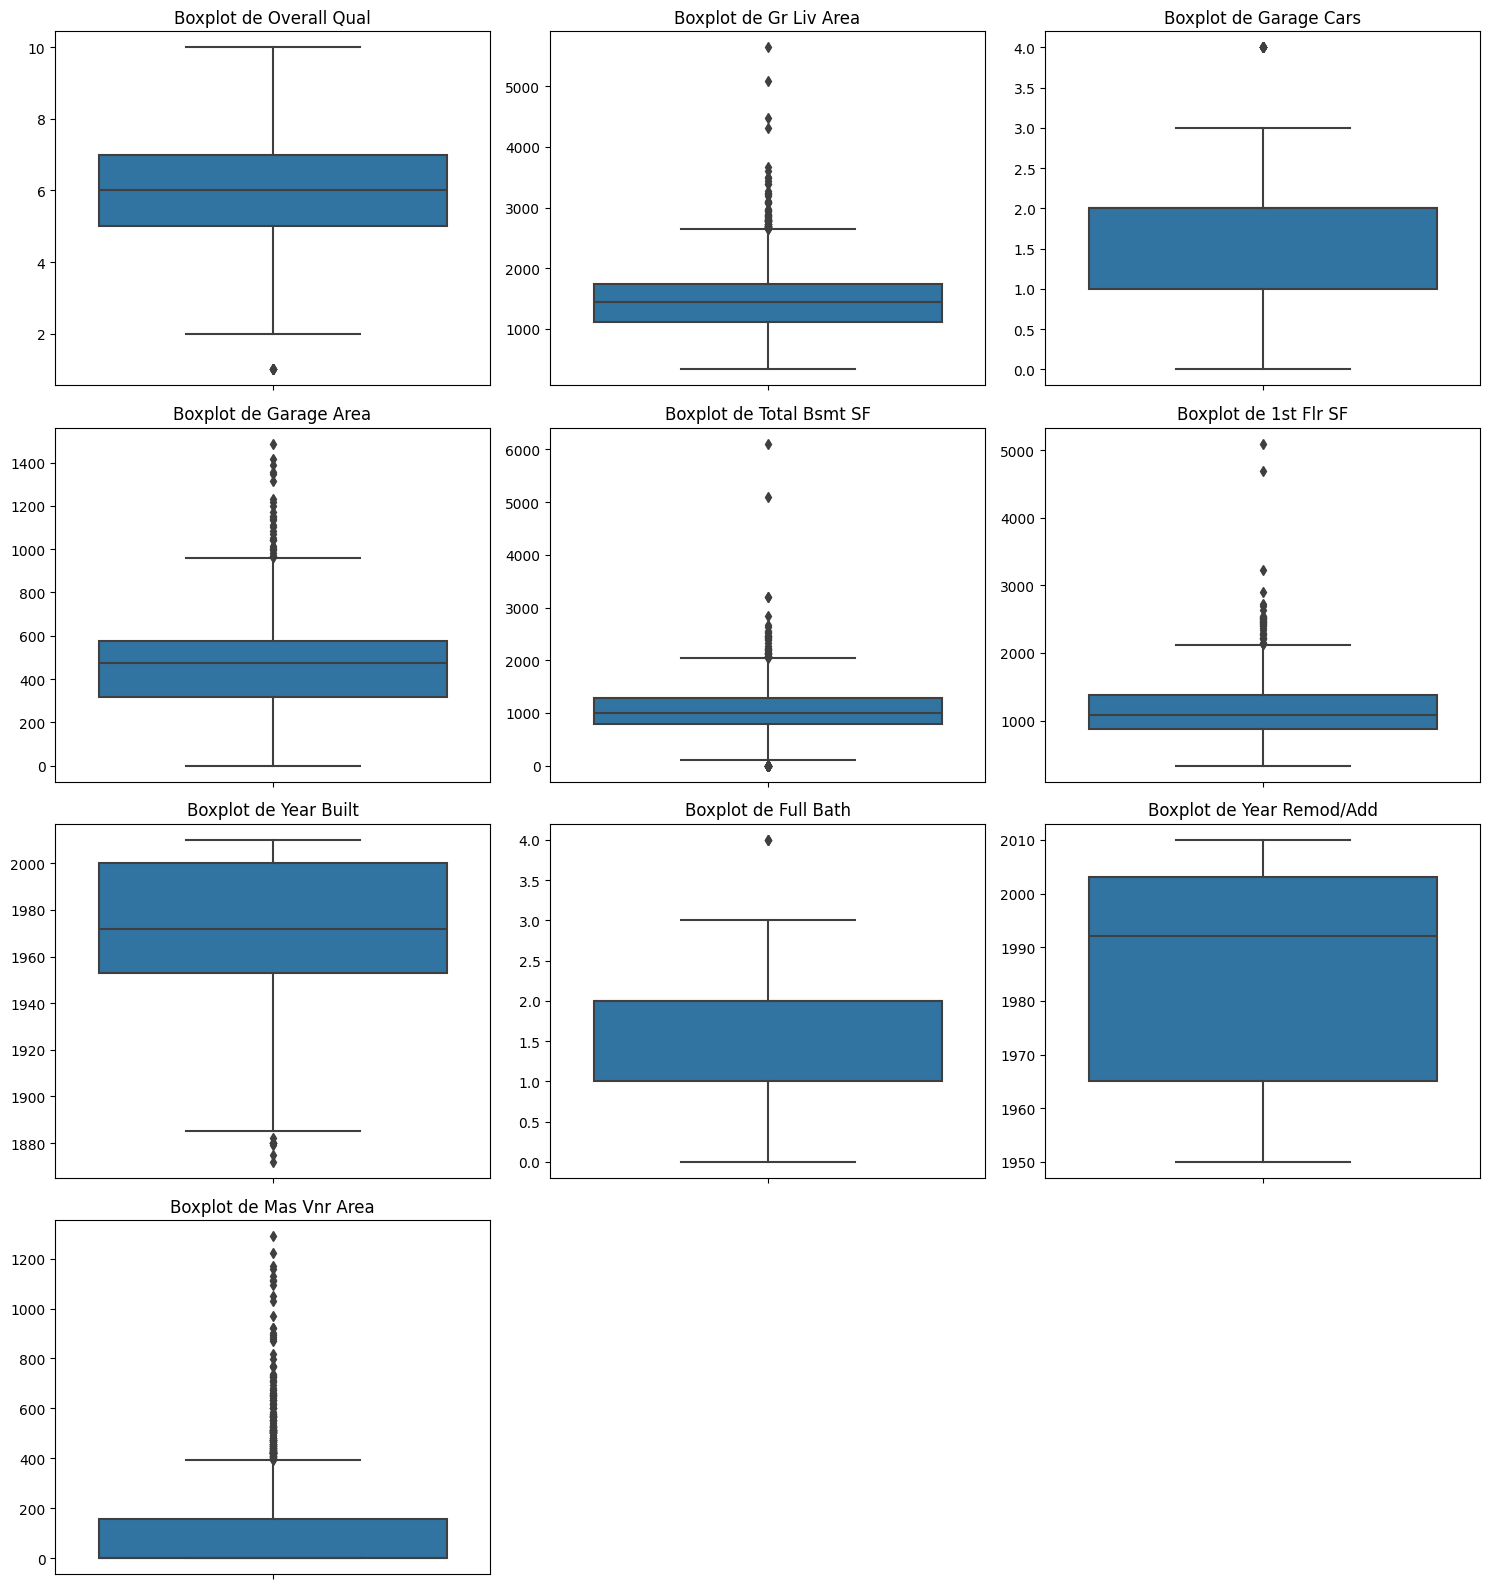

In [20]:
n_cols = 3
n_rows = (len(numeric_great_corr_varrs) + n_cols - 1) // n_cols

plt.figure(figsize=(5*n_cols, 4*n_rows))

for i, col in enumerate(numeric_great_corr_varrs):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(y=train_df[col].values)
    plt.title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

Na etapa de substituição dos outliers, foram identificadas as colunas com outliers, como listadas abaixo, e, para cada uma delas, calculados os limites superior e inferior usando a média +/- 3 desvios-padrão. Os valores que ultrapassavam esses limites foram substituídos pelos limites, visando controlar a influência dos outliers sem remover nenhuma linha do dataset.

In [21]:
outliers_cols = ['1st Flr SF', 'Total Bsmt SF', 'Garage Area', 'Gr Liv Area']
z_score_threshold = 3

def replace_outliers_zscore(train_df, cols, z_thresh=3):
    df_clean = train_df.copy()
    
    for col in cols:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        upper = mean + z_thresh * std
        lower = mean - z_thresh * std
        
        df_clean[col] = np.where(df_clean[col] > upper, upper, df_clean[col])
        df_clean[col] = np.where(df_clean[col] < lower, lower, df_clean[col])

    return df_clean

train_df = replace_outliers_zscore(train_df, outliers_cols, z_score_threshold)
train_df.sample(3)

,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Year Built,Full Bath,Year Remod/Add,Mas Vnr Area,...,Neighborhood,Exter Qual,Kitchen Qual,Bsmt Qual,Garage Finish,Garage Qual,House Style,Sale Condition,MS Zoning,SalePrice
1433,5,1314.0,1.0,294.0,1314.0,1314.0,1957,1,1957,0.0,...,NAmes,TA,TA,TA,RFn,TA,1Story,Normal,RL,145000
824,6,987.0,1.0,264.0,483.0,483.0,1971,1,1971,232.0,...,BrDale,TA,TA,TA,Unf,TA,2Story,Abnorml,RM,85400
2233,6,1072.0,2.0,525.0,547.0,1072.0,2005,1,2005,76.0,...,Edwards,TA,Gd,Gd,Fin,TA,SFoyer,Normal,RM,140000


Na célula seguinte, criei uma função para codificar as variáveis categóricas do dataset usando one-hot encoding. Isto é, para cada coluna categórica, foram criadas colunas binárias representando cada categoria (com True/False), mantendo as colunas numéricas como estavam e garantindo que os modelos de machine learning consigam interpretar corretamente essas informações.

In [22]:
categorical_columns_to_encode =  ['Neighborhood', 'Exter Qual', 'Kitchen Qual', 'Bsmt Qual',
                                'Garage Finish', 'Garage Qual', 'House Style', 'Sale Condition', 'MS Zoning']

def encode_categorical(df, categorical_columns_to_encode):
    df_encoded = df.copy()
    
    for col in categorical_columns_to_encode:
        if df_encoded[col].dtype == 'bool':
            df_encoded[col] = df_encoded[col].astype(int)
    
    df_encoded = pd.get_dummies(df_encoded, columns=categorical_columns_to_encode, drop_first=True, dtype=int)
    
    return df_encoded

train_df = encode_categorical(train_df, categorical_columns_to_encode)
train_df = train_df.loc[:,~train_df.columns.duplicated()].copy()
train_df.sample(3)

,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Year Built,Full Bath,Year Remod/Add,Mas Vnr Area,...,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM
1933,5,1539.0,2.0,576.0,927.0,1067.0,1936,1,1950,0.0,...,0,0,1,0,0,0,0,0,0,1
1780,4,1510.0,2.0,720.0,677.0,833.0,1910,2,1950,0.0,...,0,0,1,0,0,0,0,0,0,1
1843,5,778.0,1.0,924.0,740.0,778.0,1940,1,1955,0.0,...,0,0,1,0,0,0,0,0,0,1


<Axes: >

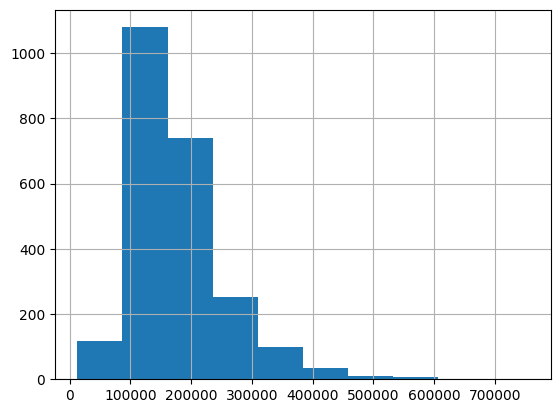

In [23]:
train_df['SalePrice'].hist()

Abaixo é aplicada a função log na variável alvo (SalePrice), transformando a distribuição em algo mais próximo da normalidade, facilitando que modelos lineares e até árvores capturem relações consistentes entre variáveis.

In [24]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
train_df['SalePrice']

0       11.931642
1       12.128117
2       11.530775
3       11.407576
4       11.456895
          ...    
2339    11.951187
2340    12.078245
2341    12.242891
2342    11.713832
2343    11.804856
Name: SalePrice, Length: 2344, dtype: float64

<Axes: >

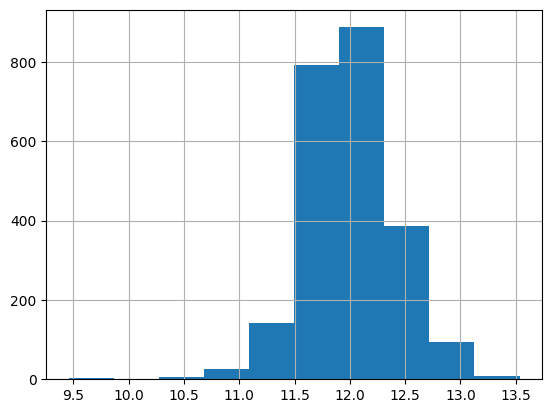

In [25]:
train_df['SalePrice'].hist()

### 3. Experimentando modelos

A célula abaixo garante que as execuções sejam reprodutíveis em caso de cálculos aleatórios nas demais etapas.

In [26]:
RANDOM_STATE = 37
np.random.seed(RANDOM_STATE)

Abaixo são divididos os dados de treino em variáveis independentes e variável alvo.

In [27]:
X = train_df.drop('SalePrice', axis=1).values
y = train_df['SalePrice'].values.ravel()

Abaixo são definidos os modelos e as grades com variedades de parâmetros para cada um. Para os modelos de Regressão Linear e Ridge, foi utilizado o módulo StandardScaler do scikit-learn que padroniza as variáveis numéricas subtraindo a média e dividindo pelo desvio padrão, garantindo que as features fiquem na mesma escala. Isso é importante para modelos lineares, porque evita que variáveis com magnitudes maiores dominem o ajuste do modelo e melhora a convergência durante a otimização dos coeficientes.

In [28]:
models = {
    'LinearRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]),
    'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE),
    'ExtraTrees': ExtraTreesRegressor(random_state=RANDOM_STATE), 
    'XGBoost': XGBRegressor(random_state=RANDOM_STATE, 
                            objective='reg:squarederror', 
                            missing=1)
}

param_grids = { 
    'Ridge': {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 50.0],
        'model__solver': ['auto', 'saga']
    },
    'RandomForest': {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'ExtraTrees': {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }, 
    'XGBoost': {
        'n_estimators': [100, 200, 400],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1, 5]
    }
}

No código abaixo, é aplicada validação cruzada com 10 divisões dos dados para cada modelo. Quando existem grades de hiperparâmetros definidas para o modelo, é utilizado o GridSearchCV, que testa todas as combinações possíveis desses parâmetros, avalia cada configuração usando validação cruzada e seleciona aquela com melhor desempenho médio. Em seguida, o melhor modelo é retreinado em todo o conjunto de dados e tanto o modelo ajustado quanto o melhor score de validação e os parâmetros escolhidos são armazenados em results.

O melhor resultado é definido de acordo com o menor neg_root_mean_squared_error, que mede o quanto, em média, as previsões de cada modelo estão distantes dos valores reais, em unidades da variável alvo.

Já para os modelos que não possuem grade de hiperparâmetros, é feito apenas um cross_val_score para calcular a média dos scores de validação cruzada, e depois o modelo é treinado em todo o conjunto. Nesse caso, são salvos em results o modelo final, a média dos scores de validação e None para os parâmetros. Assim, por fim, results contém, para cada modelo, a versão treinada em todos os dados, a métrica de validação cruzada correspondente e os melhores hiperparâmetros encontrados.

In [ ]:
results = {}

cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

for name, model in tqdm(models.items(), desc="Treinando modelos"):
    if name in param_grids:
        grid = GridSearchCV(
            model,
            param_grids[name],
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid.fit(X, y)
        best_model = grid.best_estimator_
        best_score = -grid.best_score_
        results[name] = {
            'model': best_model,
            'score': best_score,
            'best_params': grid.best_params_
        }
    else:
        scores = cross_val_score(
            model,
            X,
            y,
            cv=cv,
            scoring='neg_root_mean_squared_error'
        )
        model.fit(X, y)
        results[name] = {
            'model': model,
            'score': -np.mean(scores),
            'best_params': None
        }

Treinando modelos: 100%|██████████| 5/5 [15:58<00:00, 191.62s/it]


O melhor modelo, exibido abaixo, foi o XGBoost e apresentou um erro médio de 0.1411, tomando como medida a unidade da variável alvo (SalePrice, convertida com log). Isso indica que, em média, o modelo erra cerca de exp(0.1411) - 1, que é aproximadamente 0.15 vezes o valor logarítmico do preço, ou seja, é um erro relativamente pequeno no log.

In [78]:
best_model_name = min(results, key=lambda k: results[k]['score'])
best_model = results[best_model_name]['model']

print("Melhor modelo:", best_model_name)
print("Score (RMSE CV):", results[best_model_name]['score'])

Melhor modelo: XGBoost
Score (RMSE CV): 0.14116874465870172


In [ ]:
# Salvar melhor modelo

joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

### 4. Carregando melhor modelo e fazendo teste final

In [29]:
# Carrega o melhor modelo

best_model = joblib.load('best_model.pkl')
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


A função abaixo recebe o path de um arquivo csv, encapsula todos os tratamentos feitos durante a fase de preparação das variáveis de treino, e retorna as predições convertidas para a escala original da variável SalePrice.

In [32]:
def predict_from_csv(csv_path, model_path, train_columns):
    categoric_cols_none = [
        'Alley', 'Mas Vnr Type', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
        'BsmtFin SF 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Type',
        'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC',
        'Fence', 'Misc Feature'
    ]

    numeric_cols_zero = [
        'Mas Vnr Area', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
        'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
        'Garage Cars', 'Garage Area', 'Garage Yr Blt'
    ]

    categorical_columns_to_encode = [
        'Neighborhood', 'Exter Qual', 'Kitchen Qual', 'Bsmt Qual',
        'Garage Finish', 'Garage Qual', 'House Style', 'Sale Condition', 'MS Zoning'
    ]

    def encode_categorical(df, categorical_columns_to_encode):
        df_encoded = df.copy()
        for col in categorical_columns_to_encode:
            if df_encoded[col].dtype == 'bool':
                df_encoded[col] = df_encoded[col].astype(int)
        df_encoded = pd.get_dummies(
            df_encoded,
            columns=categorical_columns_to_encode,
            drop_first=True,
            dtype=int
        )
        return df_encoded

    df = pd.read_csv(csv_path, sep = ';')

    for col in categoric_cols_none:
        if col in df:
            df[col] = df[col].fillna("None")

    for col in numeric_cols_zero:
        if col in df:
            df[col] = df[col].fillna(0)

    if "Lot Frontage" in df:
        df["Lot Frontage"] = df.groupby("Neighborhood")["Lot Frontage"].transform(
            lambda x: x.fillna(x.median())
        )
        df["Lot Frontage"] = df["Lot Frontage"].fillna(df["Lot Frontage"].median())

    df = encode_categorical(df, categorical_columns_to_encode)
    df = df.loc[:, ~df.columns.duplicated()].copy()

    for col in train_columns:
        if col not in df:
            df[col] = 0

    df = df[train_columns]

    best_model = joblib.load(model_path)
    y_pred_log = best_model.predict(df)
    y_pred = np.expm1(y_pred_log)
    return y_pred

Abaixo, por fim, é executado o melhor modelo para prever os casos da base de dados de teste.

In [33]:
X_train_columns = [
    'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
    'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath',
    'Year Remod/Add', 'Mas Vnr Area', 'Neighborhood_Blueste',
    'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
    'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
    'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill',
    'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV',
    'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
    'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
    'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
    'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
    'Neighborhood_Timber', 'Neighborhood_Veenker', 'Exter Qual_Fa',
    'Exter Qual_Gd', 'Exter Qual_TA', 'Kitchen Qual_Fa', 'Kitchen Qual_Gd',
    'Kitchen Qual_TA', 'Bsmt Qual_Fa', 'Bsmt Qual_Gd', 'Bsmt Qual_None',
    'Bsmt Qual_Po', 'Bsmt Qual_TA', 'Garage Finish_None',
    'Garage Finish_RFn', 'Garage Finish_Unf', 'Garage Qual_Fa',
    'Garage Qual_Gd', 'Garage Qual_None', 'Garage Qual_Po',
    'Garage Qual_TA', 'House Style_1.5Unf', 'House Style_1Story',
    'House Style_2.5Fin', 'House Style_2.5Unf', 'House Style_2Story',
    'House Style_SFoyer', 'House Style_SLvl', 'Sale Condition_AdjLand',
    'Sale Condition_Alloca', 'Sale Condition_Family',
    'Sale Condition_Normal', 'Sale Condition_Partial', 'MS Zoning_C (all)',
    'MS Zoning_FV', 'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL',
    'MS Zoning_RM'
]

test_df = pd.read_csv("test.csv", sep=';')
predictions = predict_from_csv("test.csv", "best_model.pkl", X_train_columns)

y_true = test_df["SalePrice"].values
rmse = np.sqrt(mean_squared_error(y_true, predictions))

print("RMSE no test set:", rmse)

RMSE no test set: 49319.654175592106


O RMSE nos dados de teste mostra como o modelo performa em dados que ele não viu antes.

Um RMSE de 49.319 significa que, em média, a previsão do modelo erra cerca de 49.319 dólares por casa.

Nesse dataset, os preços variam bastante, indo de cerca de 13000 até mais de 750.000 dólares. Então um erro de 49.319 dólares é moderado.

In [36]:
results_df = pd.DataFrame({
    "Order": test_df["Order"],
    "PID": test_df["PID"],
    "SalePrice": predictions
})

results_df.to_csv("test_predictions.csv", index=False)
print("Predições salvas em test_predictions.csv")

Predições salvas em test_predictions.csv
